In [1]:
pip install cleverminer

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


# Script

In [3]:
from heapq import merge
import pandas as pd
import numpy as np
import io
import matplotlib.pyplot as plt
from cleverminer import cleverminer
from sklearn.metrics import matthews_corrcoef
import seaborn as sns

Cleverminer version  1.0.2  educational version. For production use (bugfixes and keeping compatibility), ask for PRO version.



**Loading files to Google Collab**

In [4]:
# from google.colab import files
 
# insurance_data.csv.zip
# data_claims_file = files.upload() 

In [5]:
# vendor_data.csv
# data_vendor_file = files.upload() 

In [6]:
# employee_data.csv
# data_employee_file = files.upload() 

In [7]:
# all-states-history.csv.zip
# data_covid_file = files.upload() 

In [8]:
# CPIAUCSL.csv
# data_cpi_file = files.upload() 

In [9]:
# ^VIX.csv
# data_vol_file = files.upload() 

In [10]:
# ststdnsadata_col_name.xlsx
# data_unemployment_file = files.upload()

In [11]:
# state_codes.txt
# data_us_states_file = files.upload()

**Loading files from Google Collab to dataframes**

In [12]:
data_claims = pd.read_csv('./data/insurance/insurance_data.csv.zip')
data_vendor = pd.read_csv('./data/insurance/vendor_data.csv')
data_employee = pd.read_csv('./data/insurance/employee_data.csv')

data_covid = pd.read_csv('./data/covid/all-states-history.csv.zip')
data_covid_agg = pd.read_excel('./data/covid/covid.xlsx')

data_cpi = pd.read_csv('./data/makroeko/CPIAUCSL.csv')
data_vol = pd.read_csv('./data/makroeko/^VIX.csv')
data_unemployment = pd.read_excel('./data/makroeko/ststdnsadata_col_name.xlsx', skiprows=7)

data_us_states = pd.read_csv('./data/states/state_codes.txt', sep="|")

In [13]:
data_covid_agg

,Date_covid,Cases_covid
0,2020-01-20,1
1,2020-01-21,0
2,2020-01-22,0
3,2020-01-23,0
4,2020-01-24,0
...,...,...
978,2022-09-24,24419
979,2022-09-25,57464
980,2022-09-26,33699
981,2022-09-27,11151


Setting datatypes

In [14]:
data_covid_agg['Date_covid'] = pd.to_datetime(data_covid_agg['Date_covid'])


In [15]:
data_claims['TXN_DATE_TIME'] = pd.to_datetime(data_claims['TXN_DATE_TIME'])
data_covid['date'] = pd.to_datetime(data_covid['date'])
data_cpi['DATE'] = pd.to_datetime(data_cpi['DATE'])
data_vol['Date'] = pd.to_datetime(data_vol['Date'])

In [16]:
data_unemployment['Day'] = 1
data_unemployment['date'] = pd.to_datetime(data_unemployment[['Year', 'Month', 'Day']])

Adding state codes to unemployment data

In [17]:
data_unemployment = data_unemployment.merge(data_us_states[['STUSAB', 'STATE_NAME']], how='left', left_on='State and area', right_on='STATE_NAME')

[DONE] edit state to shortcut, <br>
[DONE] edit loading file from row 2 (3 in excel), <br>
[DONE] create datetime column

Completeness Check of states

In [18]:
CC_us_states = pd.DataFrame(data_covid['state'].unique(), columns=['STUSAB']).merge(data_us_states, on='STUSAB', how='left')
CC_us_states[CC_us_states['STATE'].isna()]

,STUSAB,STATE,STATE_NAME,STATENS


date monotonic increasing check

In [19]:
data_claims['TXN_DATE_TIME'].is_monotonic_increasing

True

%% <br>
Adding diff values

ata_cpi['monthly_change_%'] = 

ata_cpi['CPIAUCSL'] = data_cpi.apply(lambda x: np.log(x['CPIAUCSL'] / x['CPIAUCSL'].shift(1)), axis = 1)

%%<br>
Joining data

In [20]:
data_merge = data_claims

In [21]:
data_merge = data_merge.merge(data_employee, how= 'left', on = 'AGENT_ID')

In [22]:
data_merge = data_merge.merge(data_vendor, how= 'left', on = 'VENDOR_ID')

In [23]:
data_merge = data_merge.merge(data_covid, how= 'left', left_on= ['TXN_DATE_TIME', 'STATE'], right_on= ['date', 'state'])

In [24]:
data_merge = data_merge.merge(data_covid_agg, how= 'left', left_on= ['TXN_DATE_TIME'], right_on= ['Date_covid'])

In [25]:
data_merge = data_merge.merge(data_cpi, how='left', left_on='TXN_DATE_TIME', right_on='DATE')
data_merge['CPIAUCSL'] = data_merge['CPIAUCSL'].ffill()

In [26]:
data_merge = data_merge.merge(data_vol, how='left', left_on='TXN_DATE_TIME', right_on='Date')
data_merge[data_vol.columns] = data_merge[data_vol.columns].ffill()

In [27]:
data_merge = data_merge.merge(data_unemployment, how='left', left_on=['TXN_DATE_TIME', 'STATE_x'], right_on=['date', 'STUSAB'])
data_merge[data_unemployment.columns[data_unemployment.columns != 'date']] = data_merge[data_unemployment.columns[data_unemployment.columns != 'date']].ffill()

%%
Plotting variables

In [28]:
# navigace sloupecky (protoze vsech 118 se najednou nevypise)
data_merge.columns[24]

'SOCIAL_CLASS'

In [29]:
column_names = list(data_merge.columns)
print(column_names)

['TXN_DATE_TIME', 'TRANSACTION_ID', 'CUSTOMER_ID', 'POLICY_NUMBER', 'POLICY_EFF_DT', 'LOSS_DT', 'REPORT_DT', 'INSURANCE_TYPE', 'PREMIUM_AMOUNT', 'CLAIM_AMOUNT', 'CUSTOMER_NAME', 'ADDRESS_LINE1_x', 'ADDRESS_LINE2_x', 'CITY_x', 'STATE_x', 'POSTAL_CODE_x', 'SSN', 'MARITAL_STATUS', 'AGE', 'TENURE', 'EMPLOYMENT_STATUS', 'NO_OF_FAMILY_MEMBERS', 'RISK_SEGMENTATION', 'HOUSE_TYPE', 'SOCIAL_CLASS', 'ROUTING_NUMBER', 'ACCT_NUMBER', 'CUSTOMER_EDUCATION_LEVEL', 'CLAIM_STATUS', 'INCIDENT_SEVERITY', 'AUTHORITY_CONTACTED', 'ANY_INJURY', 'POLICE_REPORT_AVAILABLE', 'INCIDENT_STATE', 'INCIDENT_CITY', 'INCIDENT_HOUR_OF_THE_DAY', 'AGENT_ID', 'VENDOR_ID', 'AGENT_NAME', 'DATE_OF_JOINING', 'ADDRESS_LINE1_y', 'ADDRESS_LINE2_y', 'CITY_y', 'STATE_y', 'POSTAL_CODE_y', 'EMP_ROUTING_NUMBER', 'EMP_ACCT_NUMBER', 'VENDOR_NAME', 'ADDRESS_LINE1', 'ADDRESS_LINE2', 'CITY', 'STATE', 'POSTAL_CODE', 'date_x', 'state', 'death', 'deathConfirmed', 'deathIncrease', 'deathProbable', 'hospitalized', 'hospitalizedCumulative', 'hosp

(array([ 531., 1065., 1104., 1093., 1078., 1079., 1178., 1112., 1120.,
         640.]),
 array([  4. ,  16.8,  29.6,  42.4,  55.2,  68. ,  80.8,  93.6, 106.4,
        119.2, 132. ]),
 <BarContainer object of 10 artists>)

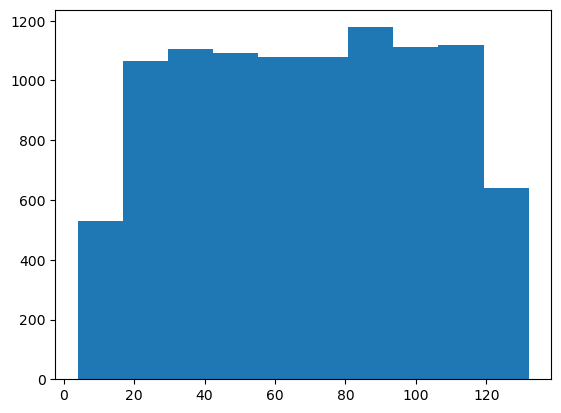

In [30]:
from datetime import datetime

data_merge["stari_sml"]=0
for row in range(len(data_merge["stari_sml"])) :
    date_1 = data_merge["POLICY_EFF_DT"][row]
    date_2 = data_merge["REPORT_DT"][row]
    start = datetime.strptime(date_1, "%Y-%m-%d")
    end =   datetime.strptime(date_2, "%Y-%m-%d")
    diff = (end.year - start.year) * 12 + (end.month  - start.month )
    data_merge.loc[row, "stari_sml"]=diff
plt.hist(data_merge['stari_sml'])

<AxesSubplot:>

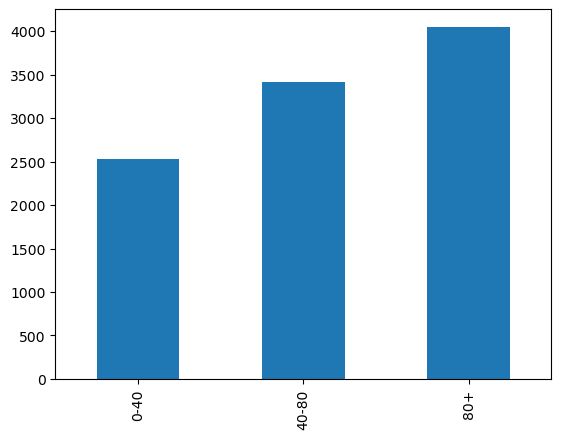

In [31]:
#binning stari smlouvy
data_merge['stari_sml_m']=pd.cut(x=data_merge['stari_sml'],
                              bins=[0, 40,80,max(data_merge["stari_sml"])],
                              labels=["0-40", "40-80","80+"],
                              include_lowest=True)
data_merge["stari_sml_m"].value_counts().loc[["0-40", "40-80","80+"]].plot.bar()

(array([2893., 1849., 1806., 1471.,  941.,  503.,  278.,  160.,   75.,
          24.]),
 array([   38.22 ,  2533.854,  5029.488,  7525.122, 10020.756, 12516.39 ,
        15012.024, 17507.658, 20003.292, 22498.926, 24994.56 ]),
 <BarContainer object of 10 artists>)

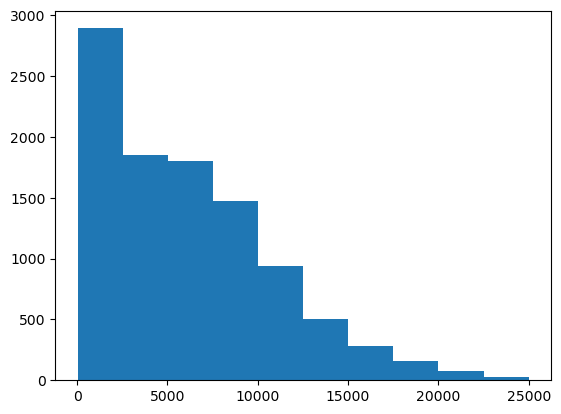

In [32]:
#vybrane pojistne za dobu trvani smlouvy
data_merge["GWP"]=data_merge["stari_sml"]*data_merge["PREMIUM_AMOUNT"]
plt.hist(data_merge["GWP"])

<AxesSubplot:>

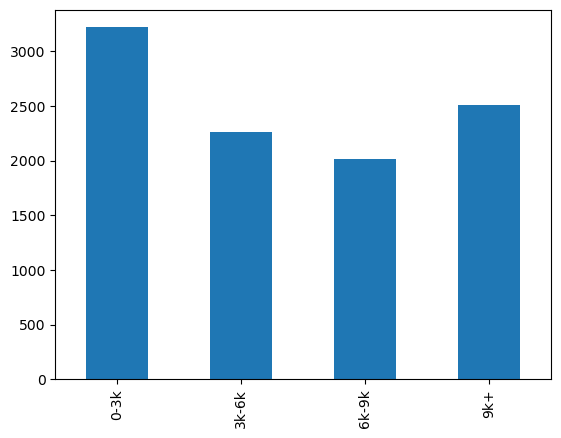

In [33]:
#binning vybraneho pojistneho
data_merge['GWP_m']=pd.cut(x=data_merge['GWP'],
                              bins=[0, 3000,6000,9000,max(data_merge["GWP"])],
                              labels=["0-3k", "3k-6k","6k-9k","9k+"],
                              include_lowest=True)
data_merge["GWP_m"].value_counts().loc[["0-3k", "3k-6k","6k-9k","9k+"]].plot.bar()

In [34]:
#derivace zratoveho pomeru
data_merge["LR"]=data_merge["CLAIM_AMOUNT"]/data_merge["GWP"]

(array([1070.,    0.,    0.,    0.,    0., 5744.,    0.,    0.,    0.,
        3186.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

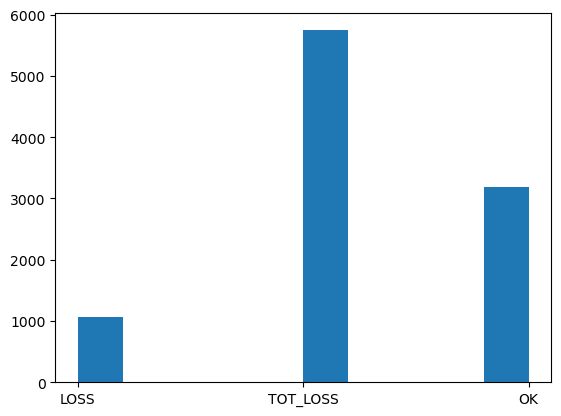

In [35]:
#Tvorba binu pro ztratovy pomer.
data_merge['LR_m']=pd.cut(x=data_merge['LR'],
                              bins=[0, 0.7,1,max(data_merge["LR"])],
                              labels=["OK", "LOSS","TOT_LOSS"],
                              include_lowest=True)
data_merge['LR_m'].describe()
plt.hist(data_merge['LR_m'])
# To rozdeleni se v pojistovnictví bezne pouziva. Vetsinou pomery okolo
# >0.7 uz byvaji ztratove, protoze do toho nejsou zahrnuty dalsi naklady.

(array([1064., 1023., 2007.,  965.,  975.,  983.,  455., 1001.,  511.,
        1016.]),
 array([ 1. ,  2.4,  3.8,  5.2,  6.6,  8. ,  9.4, 10.8, 12.2, 13.6, 15. ]),
 <BarContainer object of 10 artists>)

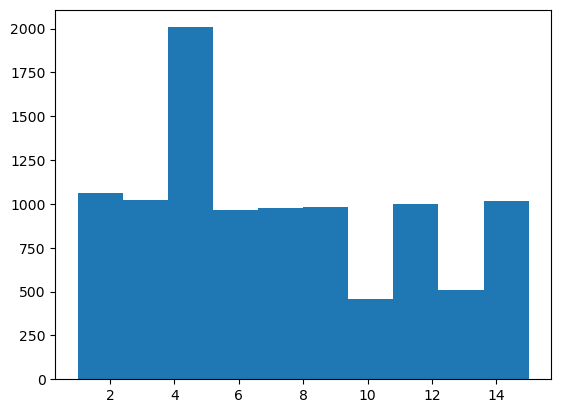

In [36]:
#Doba reseni udalosti
data_merge["doba_reseni"] = data_merge["TXN_DATE_TIME"]-pd.to_datetime(data_merge["REPORT_DT"])
data_merge["doba_reseni"] = data_merge["doba_reseni"].dt.days

plt.hist(data_merge["doba_reseni"])

<AxesSubplot:>

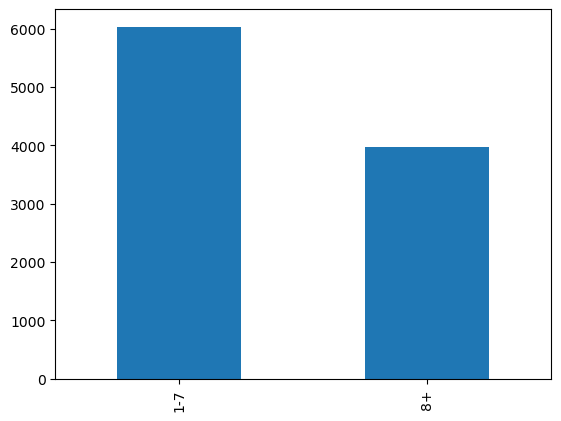

In [37]:
#Binning doby reseni
data_merge['doba_reseni_m']=pd.cut(x=data_merge['doba_reseni'],
                              bins=[0, 7,max(data_merge["doba_reseni"])],
                              labels=["1-7", "8+"],
                              include_lowest=True)
data_merge["doba_reseni_m"].value_counts().loc[["1-7", "8+"]].plot.bar()

(array([ 708., 1003., 1170., 1184., 1113., 1033., 1116., 1131.,  996.,
         546.]),
 array([ 2. ,  4.9,  7.8, 10.7, 13.6, 16.5, 19.4, 22.3, 25.2, 28.1, 31. ]),
 <BarContainer object of 10 artists>)

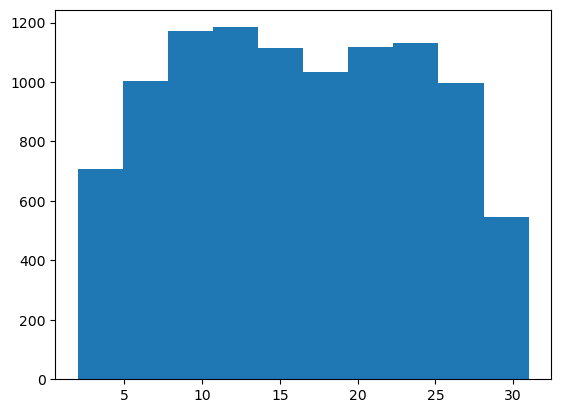

In [38]:
#Odpracovane roky
data_merge["odprac_rok"]=0
for row in range(len(data_merge["odprac_rok"])) :
    date_1 = data_merge["DATE_OF_JOINING"][row]
    date_2 = data_merge["REPORT_DT"][row]
    start = datetime.strptime(date_1, "%Y-%m-%d")
    end =   datetime.strptime(date_2, "%Y-%m-%d")
    if (end.month < start.month):
        data_merge.loc[row, "odprac_rok"]=end.year-start.year-1
    elif (end.month == start.month & end.day < start.day):
        data_merge.loc[row, "odprac_rok"]=end.year-start.year-1
    else:
        data_merge.loc[row, "odprac_rok"]=end.year-start.year
plt.hist(data_merge["odprac_rok"])

<AxesSubplot:>

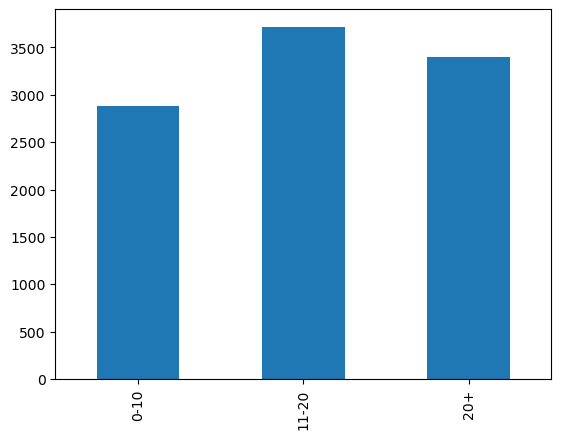

In [39]:
#binning odprac let
data_merge['odprac_rok_m']=pd.cut(x=data_merge['odprac_rok'],
                              bins=[0, 10,20,max(data_merge["odprac_rok"])],
                              labels=["0-10", "11-20","20+"],
                              include_lowest=True)
data_merge["odprac_rok_m"].value_counts().loc[["0-10", "11-20","20+"]].plot.bar()

<AxesSubplot:>

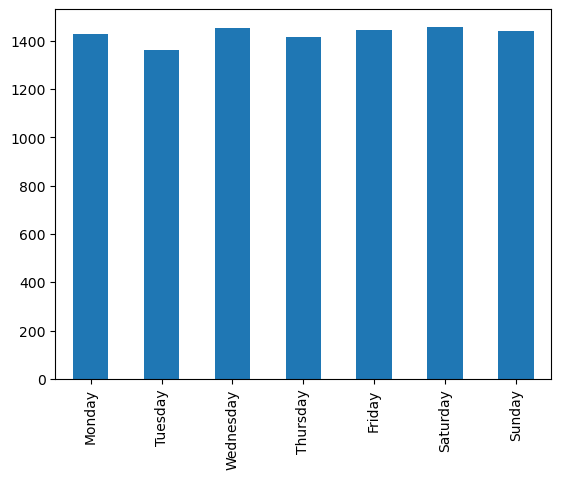

In [40]:
#Derivace dne udalosti
#data_merge["LOSS_DT"] = pd.to_datetime(data_merge["LOSS_DT"])
data_merge["den_udalosti"]= pd.to_datetime(data_merge["LOSS_DT"]).dt.day_name()
data_merge["den_udalosti"].value_counts().loc[["Monday","Tuesday",
"Wednesday","Thursday","Friday","Saturday","Sunday"]].plot.bar()

<AxesSubplot:>

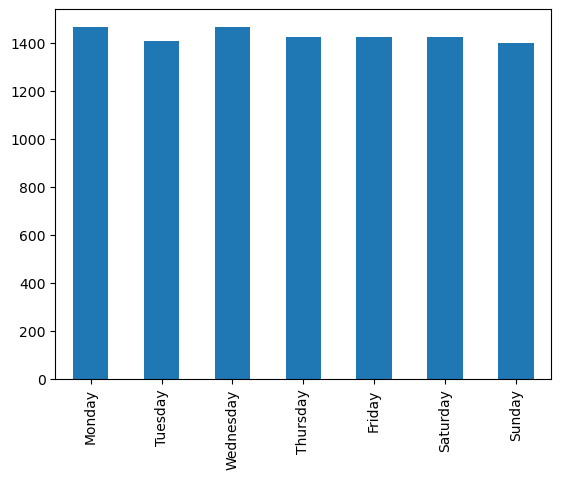

In [41]:
#Den hlaseni
#data_merge["REPORT_DT"] = pd.to_datetime(data_merge["REPORT_DT"])
data_merge["den_hlaseni"]= pd.to_datetime(data_merge["REPORT_DT"]).dt.day_name()
data_merge["den_hlaseni"].value_counts().loc[["Monday","Tuesday",
"Wednesday","Thursday","Friday","Saturday","Sunday"]].plot.bar()

(array([2727.,    0.,    0.,    0.,    0., 4794.,    0.,    0.,    0.,
        2479.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

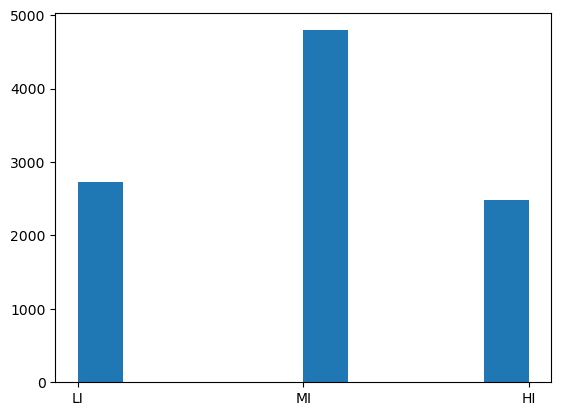

In [42]:
# zobrazeni histogramu promenne, nezobrazuje NaN
plt.hist(data_merge['SOCIAL_CLASS'])

(array([1., 3., 3., 2., 3., 2., 1., 0., 0., 1.]),
 array([129. , 174.2, 219.4, 264.6, 309.8, 355. , 400.2, 445.4, 490.6,
        535.8, 581. ]),
 <BarContainer object of 10 artists>)

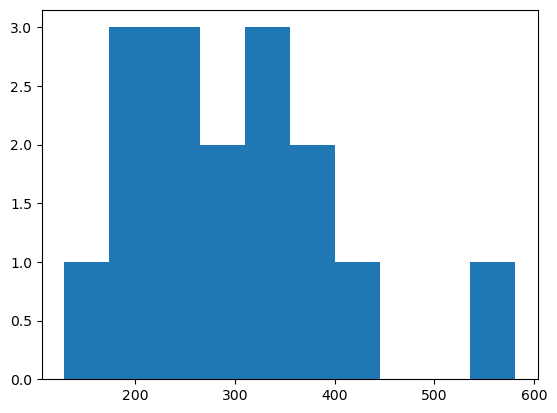

In [43]:
#Pokud vyhodi str error
plt.hist(data_merge['state'].value_counts())

In [44]:
data_merge['state'].value_counts()

CA    581
AR    435
KY    398
CO    368
GA    340
AL    334
CT    333
TN    305
DC    283
MD    239
AK    223
AZ    220
FL    219
MA    211
OK    181
VT    129
Name: state, dtype: int64

In [45]:
# vypsani vsech radku ve sloupci 'SOCIAL_CLASS' obsahujici NaN ve sloupci 'SOCIAL_CLASS'
data_merge['SOCIAL_CLASS'][data_merge['SOCIAL_CLASS'].isna()]

Series([], Name: SOCIAL_CLASS, dtype: object)

In [46]:
# pocet NaN v promenne
data_merge['Cases_covid'].isna().sum()

0

Histogramy pro jednotlivé atributy

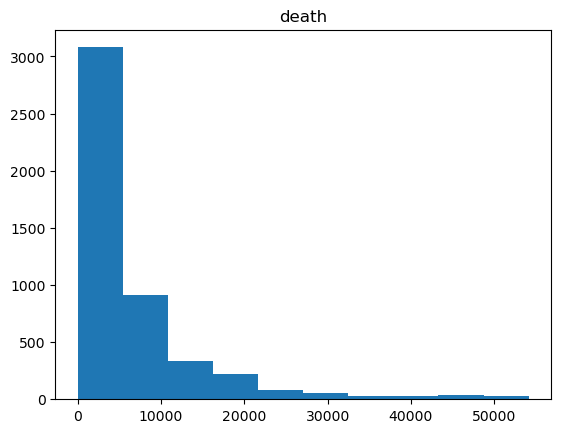

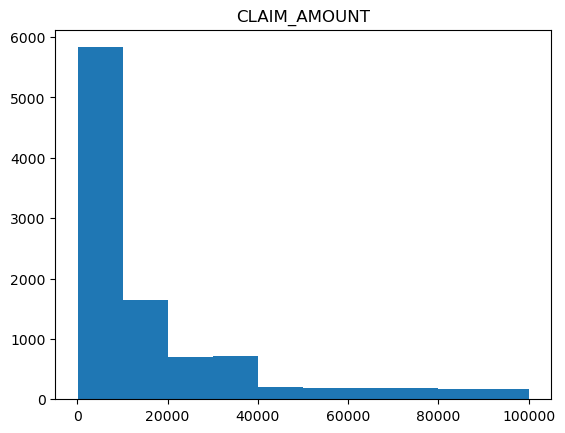

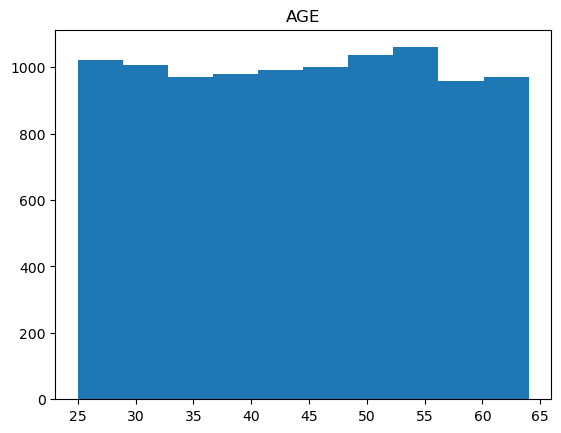

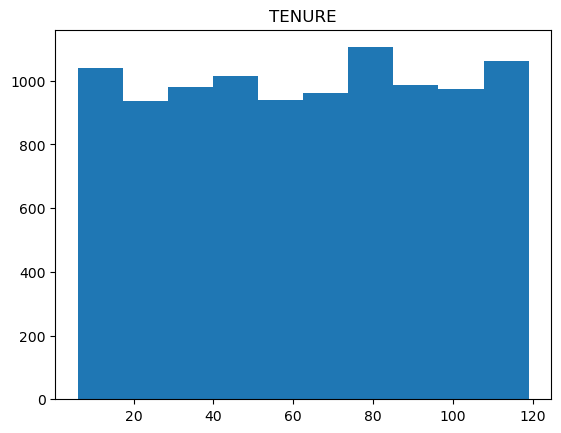

In [47]:
cols_to_plot = ['death', 'CLAIM_AMOUNT', 'AGE', 'TENURE']
# Krok 2: Vytvorim for cyklus ktery projde nazvy sloupcu
for i in range(len(cols_to_plot)):              #od i do poctu nazvu v promenne cols_to_plot
    plt.hist(data_merge[cols_to_plot[i]], )
    plt.title(cols_to_plot[i])
    plt.show()

Tvorba binu pro: AGE, TENURE, PREMIUM_AMOUNT, CLAIM_AMOUNT

In [48]:
#Tvorba binu pro dobu pojisteni (TENURE). Sirka intervalu 1 rok
data_merge['TENURE_m']=pd.cut(x=data_merge['TENURE'],
                              bins=[0, 12, 24, 36, 48, 60, 72, 84, 96, 108, 120],
                              labels=['up to 1Y', '1Y to 2Y','2Y to 3Y','3Y to 4Y','4Y to 5Y',
                                      '5Y to 6Y','6Y to 7Y','7Y to 8Y','8Y to 9Y','9Y to 10Y'],
                              include_lowest=True)
data_merge['TENURE_m'].describe()


count        10000
unique          10
top       6Y to 7Y
freq          1122
Name: TENURE_m, dtype: object

In [49]:
#Tvorba binu pro vek klienta (TENURE). Sirka intervalu 10 let
data_merge['AGE_m']=pd.cut(x=data_merge['AGE'],
                              bins=[20, 30, 40, 50, 60, 70],
                              labels=['20 to 30', '31 to 40',
                                      '41 to 50', '51 to 60', '60+'],
                           include_lowest=True)
data_merge['AGE_m'].describe()

count        10000
unique           5
top       41 to 50
freq          2527
Name: AGE_m, dtype: object

In [50]:
#Tvorba binu pro mesicni pojistne.
#Sirka intervalu 25 s vyjimkou prvniho a posledniho intrvalu -> minimum hodnot
data_merge['PREMIUM_AMOUNT_m']=pd.cut(x=data_merge['PREMIUM_AMOUNT'],
                              bins=[0, 50, 75, 100, 125, 150, 201],
                              labels=['<0;50>', '(50;75>',
                                      '(75;100>', '(100;125>', '(125;150>', '150+'],
                              include_lowest=True)
data_merge['PREMIUM_AMOUNT_m'].describe()

count        10000
unique           6
top       (75;100>
freq          2618
Name: PREMIUM_AMOUNT_m, dtype: object

(array([1692.,  585.,  584.,  563.,  567., 1525., 1786.,  799.,  726.,
         253.,  181.,  195.,  175.,  178.,  191.]),
 array([     0,   1000,   2000,   3000,   4000,   5000,  10000,  20000,
         30000,  40000,  50000,  60000,  70000,  80000,  90000, 100000]),
 <BarContainer object of 15 artists>)

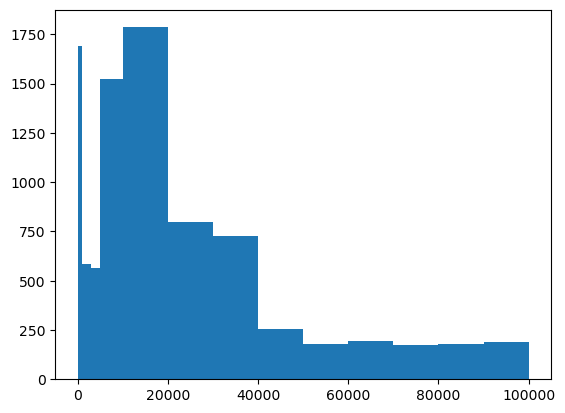

In [51]:
data_merge['CLAIM_AMOUNT'].describe()
plt.hist(data_merge['CLAIM_AMOUNT'], bins=[0,1000,2000,3000,4000,5000,10000,20000,30000,
                                    40000,50000,60000,70000,80000,90000,100000])

In [52]:
#Tvorba binu pro vyplacenou pojistku.
#Sirka intervalu 10000 s vyjimkou prvich 5 intervalu -> zahrnuje i pojisteni s obecne nizsim plnenim.
#Pro nalezeni souvislosti i v tomto segmentu pojisteni byl prvni interval rozdelen na nekolik mensich
data_merge['CLAIM_AMOUNT_m']=pd.cut(x=data_merge['CLAIM_AMOUNT'],
                              bins=[0,1000,2000,3000,4000,5000,10000,20000,30000,
                                    40000,50000,60000,70000,80000,90000,100000],
                              labels=['<0;1000>', '(1000;2000>', '(2000;3000>',
                                      '(3000;4000>', '(4000;5000>', '(5000;10000>',
                                      '(10000;20000>', '(20000;30000>', '(30000;40000>',
                                      '(40000;50000>', '(50000;60000>', '(60000;70000>',
                                       '(70000;80000>', '(80000;90000>', '(90000;100000>'],
                              include_lowest=True)
data_merge['CLAIM_AMOUNT_m'].describe()

count        10000
unique          15
top       <0;1000>
freq          2277
Name: CLAIM_AMOUNT_m, dtype: object

In [53]:
#Tvorba binu pro cas ve kterem se incident odehral.
#Vytvoreny intervaly po 4 hodinach umoznuji pri zvoleni cyklicke sekvence nachazeni souvislosti pro udalosti, ktere se odehraly rano,dopoledne,odpoledne/vecer.
data_merge['INCIDENT_HOUR_OF_THE_DAY_m']=pd.cut(x=data_merge['INCIDENT_HOUR_OF_THE_DAY'],
                              bins=[0,4,8,12,16,20,23],
                              labels=['<0;4>', '(4;8>', '(8;12>',
                                      '(12;16>', '(16;20>', '(20;23>'],
                              include_lowest=True)
print(data_merge[['INCIDENT_HOUR_OF_THE_DAY','INCIDENT_HOUR_OF_THE_DAY_m']].head(10))

   INCIDENT_HOUR_OF_THE_DAY INCIDENT_HOUR_OF_THE_DAY_m
0                         4                      <0;4>
1                         0                      <0;4>
2                        19                    (16;20>
3                        12                     (8;12>
4                        18                    (16;20>
5                         0                      <0;4>
6                        10                     (8;12>
7                        10                     (8;12>
8                        22                    (20;23>
9                         4                      <0;4>


In [54]:
#Binarizace zbylych sloupcu
data_merge["MARITAL_STATUS_m"] = data_merge["MARITAL_STATUS"].replace({"Y":1, "N":0})
data_merge["EMPLOYMENT_STATUS_m"] = data_merge["EMPLOYMENT_STATUS"].replace({"Y":1, "N":0})
data_merge["CLAIM_STATUS_m"] = data_merge["CLAIM_STATUS"].replace({"A":1, "D":0})

In [55]:
column_names = list(data_covid.columns)
print(column_names)

['date', 'state', 'death', 'deathConfirmed', 'deathIncrease', 'deathProbable', 'hospitalized', 'hospitalizedCumulative', 'hospitalizedCurrently', 'hospitalizedIncrease', 'inIcuCumulative', 'inIcuCurrently', 'negative', 'negativeIncrease', 'negativeTestsAntibody', 'negativeTestsPeopleAntibody', 'negativeTestsViral', 'onVentilatorCumulative', 'onVentilatorCurrently', 'positive', 'positiveCasesViral', 'positiveIncrease', 'positiveScore', 'positiveTestsAntibody', 'positiveTestsAntigen', 'positiveTestsPeopleAntibody', 'positiveTestsPeopleAntigen', 'positiveTestsViral', 'recovered', 'totalTestEncountersViral', 'totalTestEncountersViralIncrease', 'totalTestResults', 'totalTestResultsIncrease', 'totalTestsAntibody', 'totalTestsAntigen', 'totalTestsPeopleAntibody', 'totalTestsPeopleAntigen', 'totalTestsPeopleViral', 'totalTestsPeopleViralIncrease', 'totalTestsViral', 'totalTestsViralIncrease']


In [56]:
print(data_covid.head(5))

        date state    death  deathConfirmed  deathIncrease  deathProbable  \
0 2021-03-07    AK    305.0             NaN              0            NaN   
1 2021-03-07    AL  10148.0          7963.0             -1         2185.0   
2 2021-03-07    AR   5319.0          4308.0             22         1011.0   
3 2021-03-07    AS      0.0             NaN              0            NaN   
4 2021-03-07    AZ  16328.0         14403.0              5         1925.0   

   hospitalized  hospitalizedCumulative  hospitalizedCurrently  \
0        1293.0                  1293.0                   33.0   
1       45976.0                 45976.0                  494.0   
2       14926.0                 14926.0                  335.0   
3           NaN                     NaN                    NaN   
4       57907.0                 57907.0                  963.0   

   hospitalizedIncrease  ...  totalTestResults  totalTestResultsIncrease  \
0                     0  ...         1731628.0                  

In [57]:
missings = pd.DataFrame(columns=['Column_name', 'Missing_Ratio'])

for i in range(len(data_merge.columns)):
    data_merge[data_merge.columns[i]].isna().sum() / len(data_merge[data_merge.columns[i]])
    missings = missings.append( 
        {
            'Column_name' : data_merge.columns[i],
            'Missing_Ratio' : data_merge[data_merge.columns[i]].isna().sum() / len(data_merge[data_merge.columns[i]])
        },
        ignore_index = True        
    )

significant_var=missings[missings['Missing_Ratio'] < 0.3]
missings[missings['Missing_Ratio'] < 0.3].to_string()


/var/folders/jm/t_0fgqb560d3w58nyxy1qmy00000gn/T/ipykernel_28554/2357681514.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  missings = missings.append(
/var/folders/jm/t_0fgqb560d3w58nyxy1qmy00000gn/T/ipykernel_28554/2357681514.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  missings = missings.append(
/var/folders/jm/t_0fgqb560d3w58nyxy1qmy00000gn/T/ipykernel_28554/2357681514.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  missings = missings.append(
/var/folders/jm/t_0fgqb560d3w58nyxy1qmy00000gn/T/ipykernel_28554/2357681514.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  missings = missings.append(
/var/folders/jm/t_0f

'                               Column_name  Missing_Ratio\n0                            TXN_DATE_TIME         0.0000\n1                           TRANSACTION_ID         0.0000\n2                              CUSTOMER_ID         0.0000\n3                            POLICY_NUMBER         0.0000\n4                            POLICY_EFF_DT         0.0000\n5                                  LOSS_DT         0.0000\n6                                REPORT_DT         0.0000\n7                           INSURANCE_TYPE         0.0000\n8                           PREMIUM_AMOUNT         0.0000\n9                             CLAIM_AMOUNT         0.0000\n10                           CUSTOMER_NAME         0.0000\n11                         ADDRESS_LINE1_x         0.0000\n13                                  CITY_x         0.0054\n14                                 STATE_x         0.0000\n15                           POSTAL_CODE_x         0.0000\n16                                     SSN         0.00

In [58]:
missings[missings['Column_name'].isin(data_covid_agg.columns)]


,Column_name,Missing_Ratio
94,Date_covid,0.0
95,Cases_covid,0.0


In [59]:
#podminka data_clean
data_clean = data_merge[significant_var["Column_name"]]
data_clean = data_clean.loc[:,data_clean.columns != 'Date'] #skipping date from ^vix data for redundancy

data_clean.head()

,TXN_DATE_TIME,TRANSACTION_ID,CUSTOMER_ID,POLICY_NUMBER,POLICY_EFF_DT,LOSS_DT,REPORT_DT,INSURANCE_TYPE,PREMIUM_AMOUNT,CLAIM_AMOUNT,...,den_udalosti,den_hlaseni,TENURE_m,AGE_m,PREMIUM_AMOUNT_m,CLAIM_AMOUNT_m,INCIDENT_HOUR_OF_THE_DAY_m,MARITAL_STATUS_m,EMPLOYMENT_STATUS_m,CLAIM_STATUS_m
0,2020-06-01,TXN00000001,A00003822,PLC00008468,2015-06-23,2020-05-16,2020-05-21,Health,157.13,9000,...,Saturday,Thursday,7Y to 8Y,51 to 60,150+,(5000;10000>,<0;4>,1,1,1
1,2020-06-01,TXN00000002,A00008149,PLC00009594,2018-04-21,2020-05-13,2020-05-18,Property,141.71,26000,...,Wednesday,Monday,6Y to 7Y,60+,(125;150>,(20000;30000>,<0;4>,0,1,1
2,2020-06-01,TXN00000003,A00003172,PLC00007969,2019-10-03,2020-05-21,2020-05-26,Property,157.24,13000,...,Thursday,Tuesday,5Y to 6Y,41 to 50,150+,(10000;20000>,(16;20>,0,1,1
3,2020-06-01,TXN00000004,A00007572,PLC00009292,2016-11-29,2020-05-14,2020-05-19,Health,172.87,16000,...,Thursday,Tuesday,1Y to 2Y,31 to 40,150+,(10000;20000>,(8;12>,1,1,1
4,2020-06-01,TXN00000005,A00008173,PLC00000204,2011-12-26,2020-05-17,2020-05-22,Travel,88.53,3000,...,Sunday,Friday,1Y to 2Y,51 to 60,(75;100>,(2000;3000>,(16;20>,1,1,1


In [60]:
# print(list(significant_var))
significant_var.sort_values('Missing_Ratio', ascending=False).head(80)

,Column_name,Missing_Ratio
27,CUSTOMER_EDUCATION_LEVEL,0.0529
13,CITY_x,0.0054
42,CITY_y,0.0054
34,INCIDENT_CITY,0.0046
0,TXN_DATE_TIME,0.0000
...,...,...
39,DATE_OF_JOINING,0.0000
38,AGENT_NAME,0.0000
36,AGENT_ID,0.0000
35,INCIDENT_HOUR_OF_THE_DAY,0.0000


In [61]:
#odstraneni radku s NaN hodnotami u vybranych sloupcu s nizkym procentem NaN hodnot
#po vymazani mame z puvodnich 10 000 hodnot celkem
data_clean=data_clean.dropna(subset=['CUSTOMER_EDUCATION_LEVEL','CITY_x','CITY_y','INCIDENT_CITY'])
data_clean.head()

,TXN_DATE_TIME,TRANSACTION_ID,CUSTOMER_ID,POLICY_NUMBER,POLICY_EFF_DT,LOSS_DT,REPORT_DT,INSURANCE_TYPE,PREMIUM_AMOUNT,CLAIM_AMOUNT,...,den_udalosti,den_hlaseni,TENURE_m,AGE_m,PREMIUM_AMOUNT_m,CLAIM_AMOUNT_m,INCIDENT_HOUR_OF_THE_DAY_m,MARITAL_STATUS_m,EMPLOYMENT_STATUS_m,CLAIM_STATUS_m
0,2020-06-01,TXN00000001,A00003822,PLC00008468,2015-06-23,2020-05-16,2020-05-21,Health,157.13,9000,...,Saturday,Thursday,7Y to 8Y,51 to 60,150+,(5000;10000>,<0;4>,1,1,1
1,2020-06-01,TXN00000002,A00008149,PLC00009594,2018-04-21,2020-05-13,2020-05-18,Property,141.71,26000,...,Wednesday,Monday,6Y to 7Y,60+,(125;150>,(20000;30000>,<0;4>,0,1,1
2,2020-06-01,TXN00000003,A00003172,PLC00007969,2019-10-03,2020-05-21,2020-05-26,Property,157.24,13000,...,Thursday,Tuesday,5Y to 6Y,41 to 50,150+,(10000;20000>,(16;20>,0,1,1
3,2020-06-01,TXN00000004,A00007572,PLC00009292,2016-11-29,2020-05-14,2020-05-19,Health,172.87,16000,...,Thursday,Tuesday,1Y to 2Y,31 to 40,150+,(10000;20000>,(8;12>,1,1,1
4,2020-06-01,TXN00000005,A00008173,PLC00000204,2011-12-26,2020-05-17,2020-05-22,Travel,88.53,3000,...,Sunday,Friday,1Y to 2Y,51 to 60,(75;100>,(2000;3000>,(16;20>,1,1,1


In [62]:
#definice sloupcu ktere chceme plotnou do histogramu
sloupce = list(data_clean.columns)
sloupce = sloupce[7:]
sloupce_df=pd.DataFrame(sloupce)
print(sloupce_df)
print(sloupce)

                             0
0               INSURANCE_TYPE
1               PREMIUM_AMOUNT
2                 CLAIM_AMOUNT
3                CUSTOMER_NAME
4              ADDRESS_LINE1_x
..                         ...
75              CLAIM_AMOUNT_m
76  INCIDENT_HOUR_OF_THE_DAY_m
77            MARITAL_STATUS_m
78         EMPLOYMENT_STATUS_m
79              CLAIM_STATUS_m

[80 rows x 1 columns]
['INSURANCE_TYPE', 'PREMIUM_AMOUNT', 'CLAIM_AMOUNT', 'CUSTOMER_NAME', 'ADDRESS_LINE1_x', 'CITY_x', 'STATE_x', 'POSTAL_CODE_x', 'SSN', 'MARITAL_STATUS', 'AGE', 'TENURE', 'EMPLOYMENT_STATUS', 'NO_OF_FAMILY_MEMBERS', 'RISK_SEGMENTATION', 'HOUSE_TYPE', 'SOCIAL_CLASS', 'ROUTING_NUMBER', 'ACCT_NUMBER', 'CUSTOMER_EDUCATION_LEVEL', 'CLAIM_STATUS', 'INCIDENT_SEVERITY', 'AUTHORITY_CONTACTED', 'ANY_INJURY', 'POLICE_REPORT_AVAILABLE', 'INCIDENT_STATE', 'INCIDENT_CITY', 'INCIDENT_HOUR_OF_THE_DAY', 'AGENT_ID', 'AGENT_NAME', 'DATE_OF_JOINING', 'ADDRESS_LINE1_y', 'CITY_y', 'STATE_y', 'POSTAL_CODE_y', 'EMP_ROUTING_

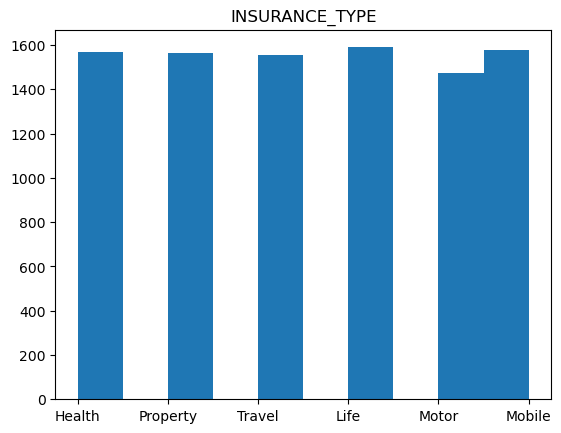

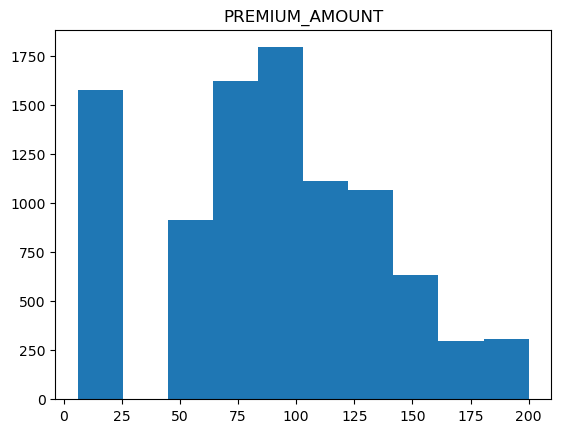

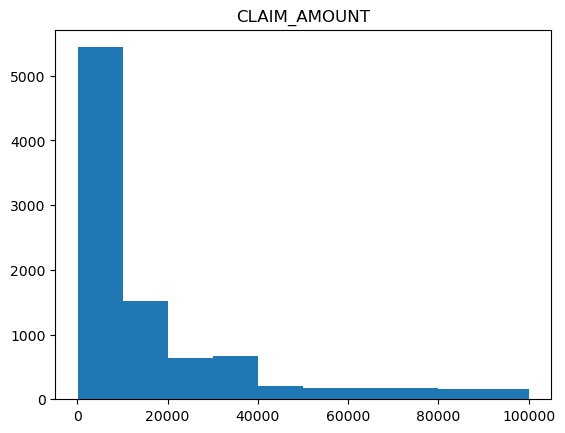

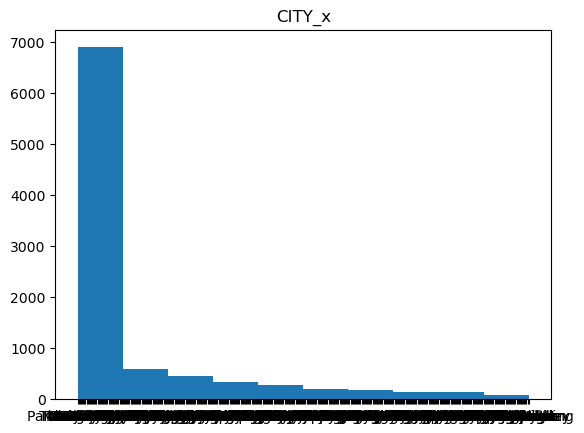

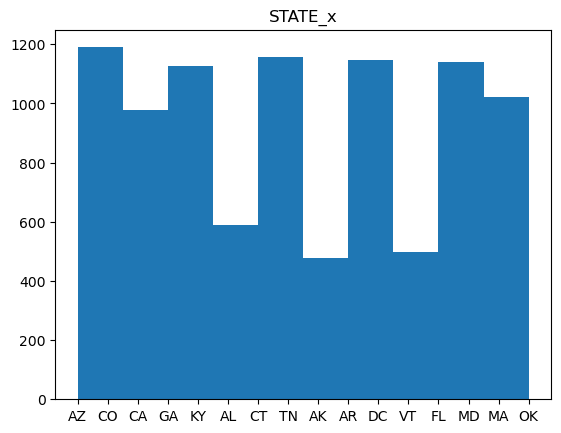

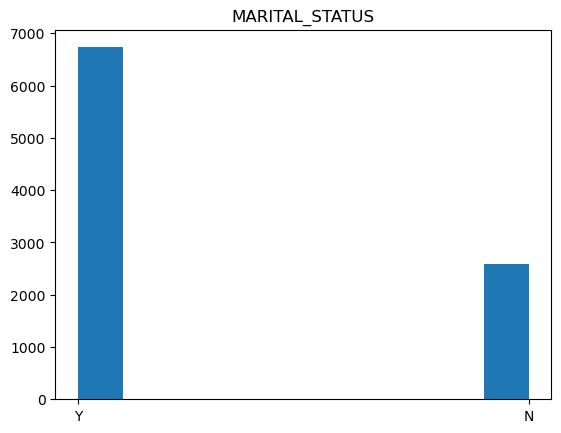

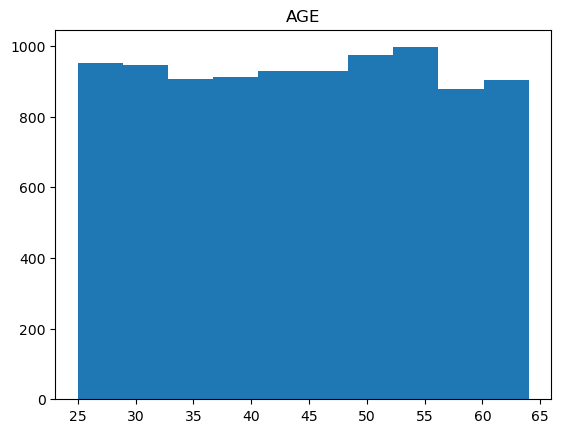

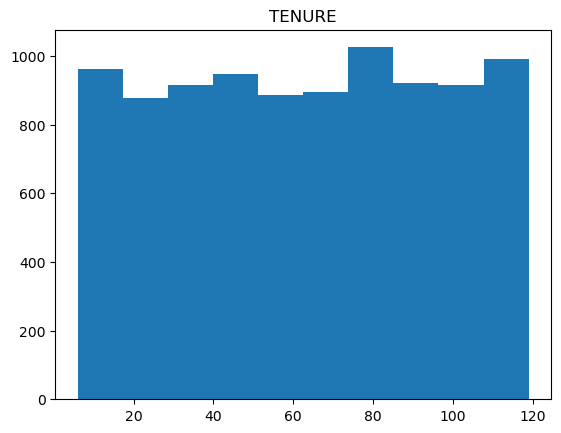

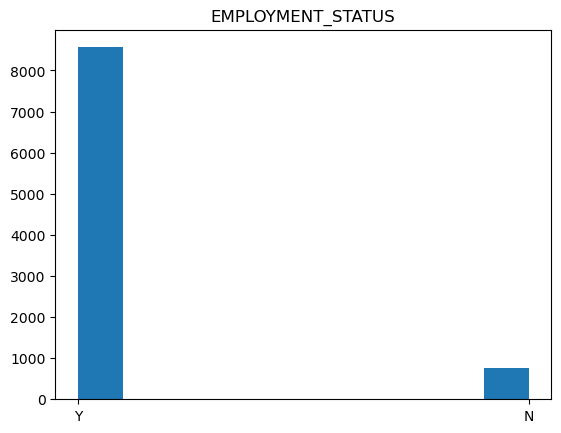

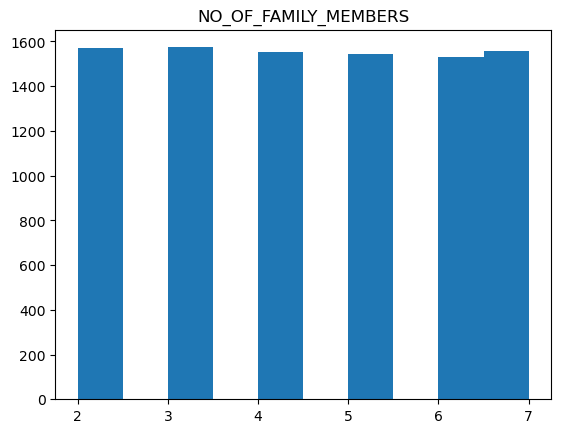

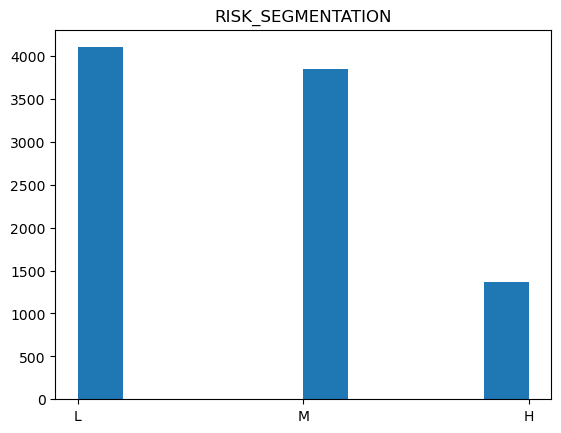

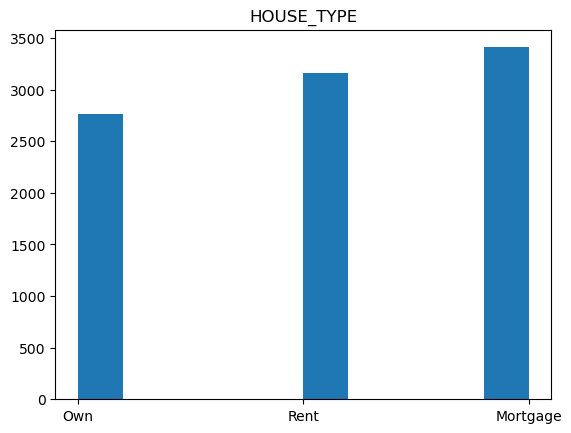

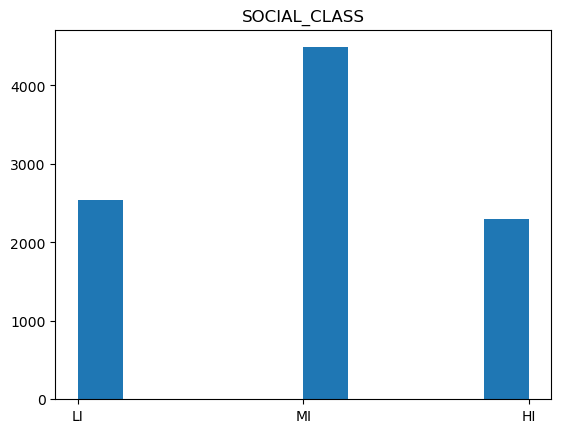

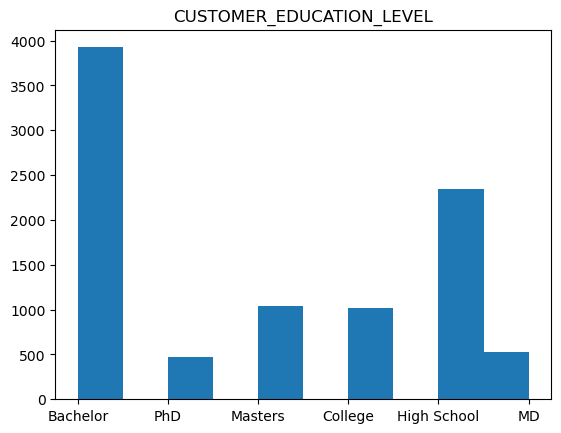

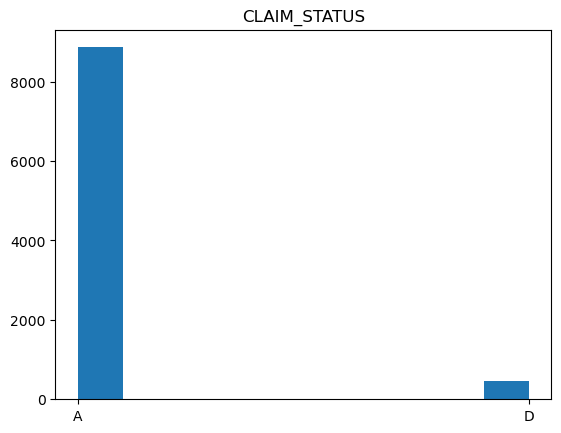

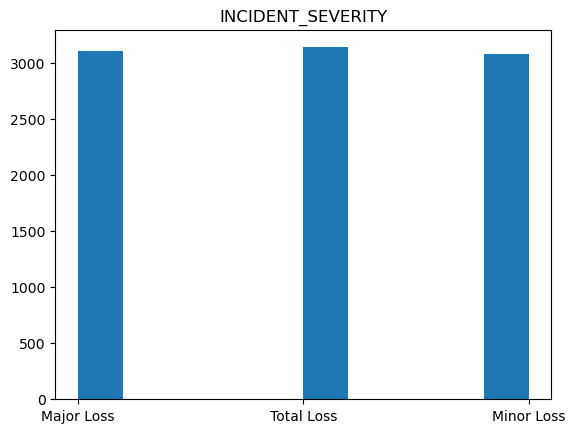

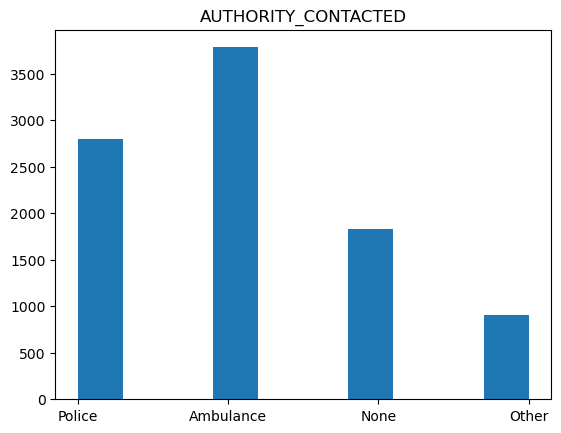

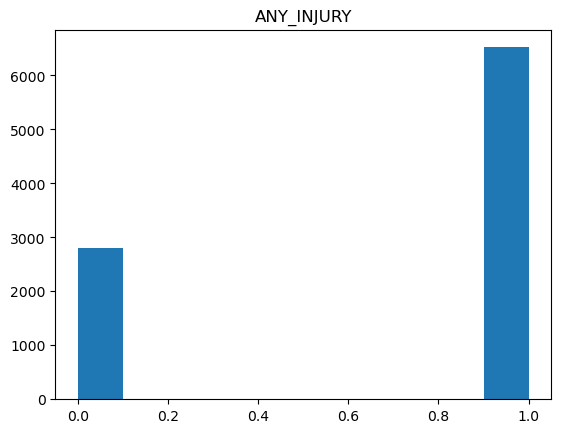

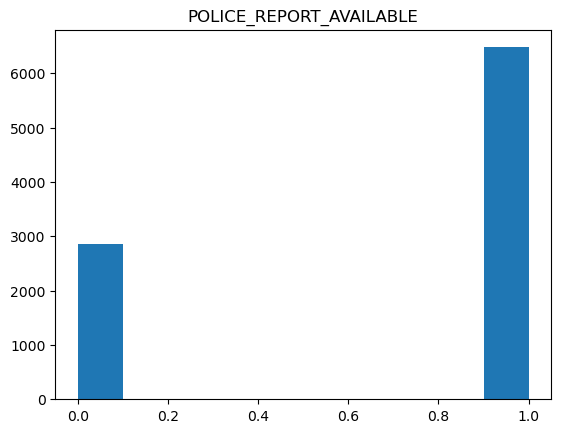

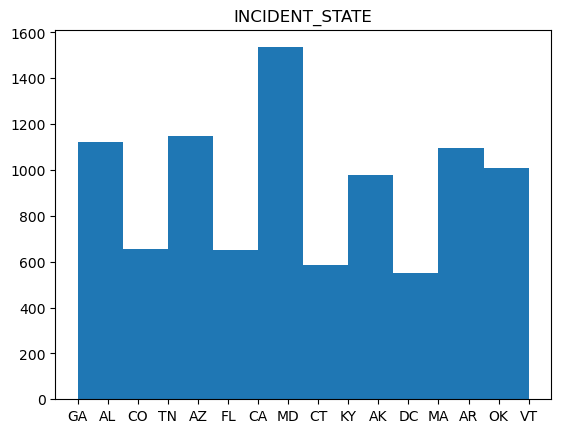

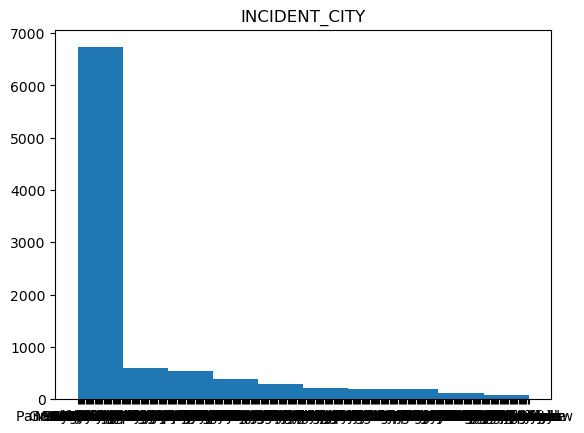

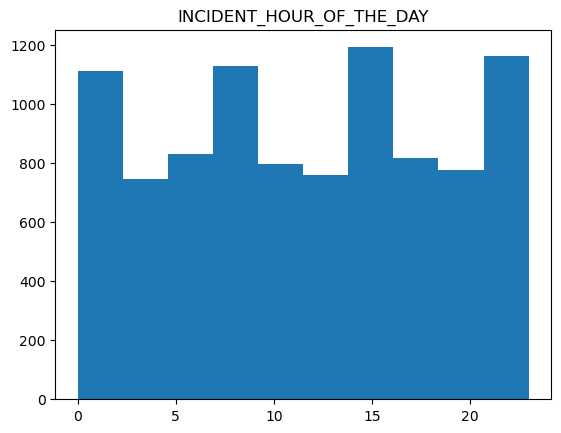

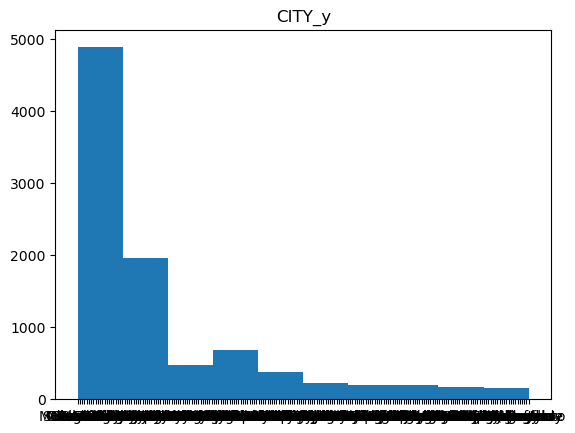

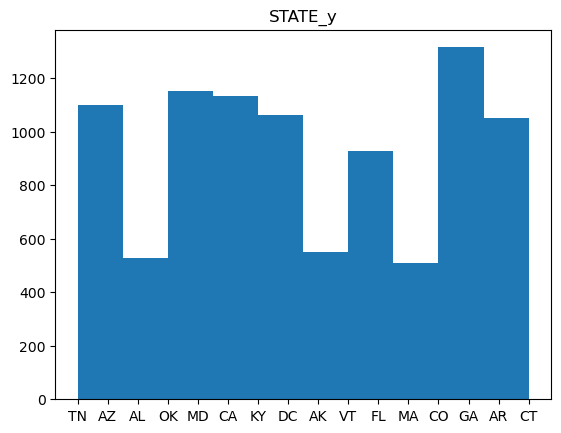

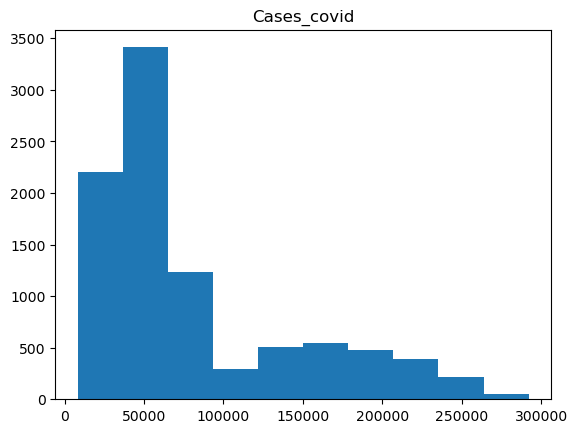

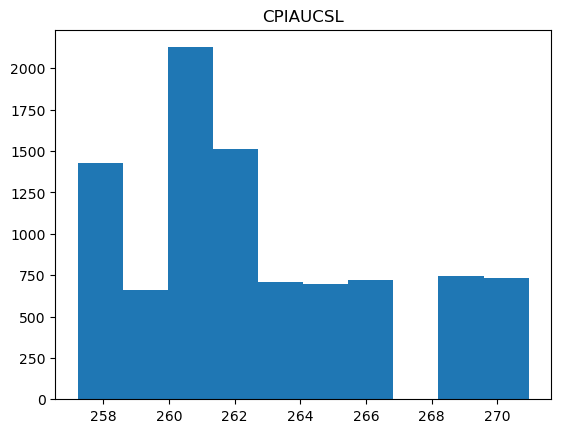

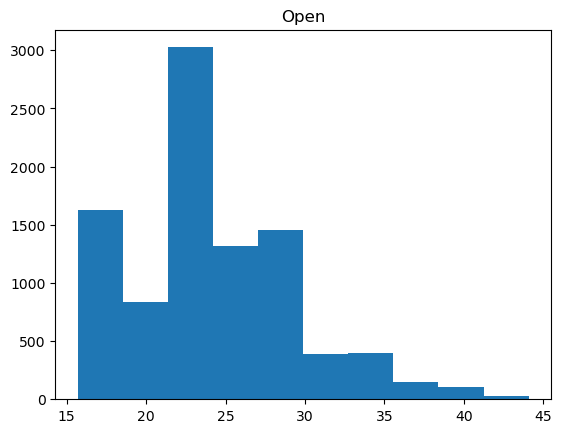

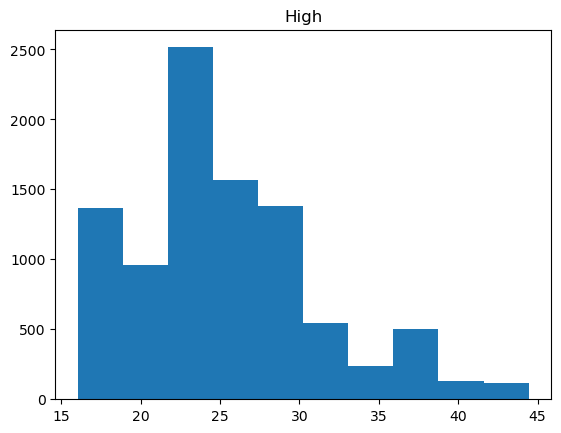

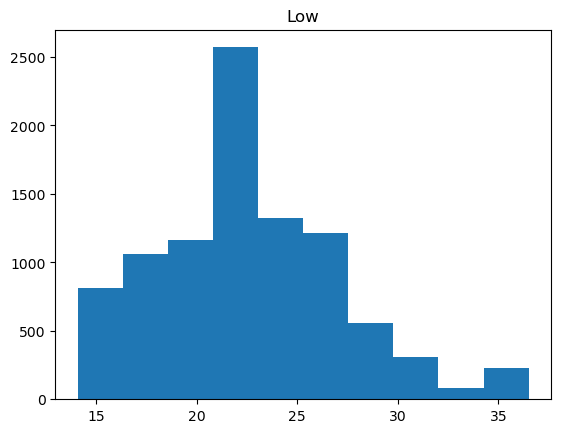

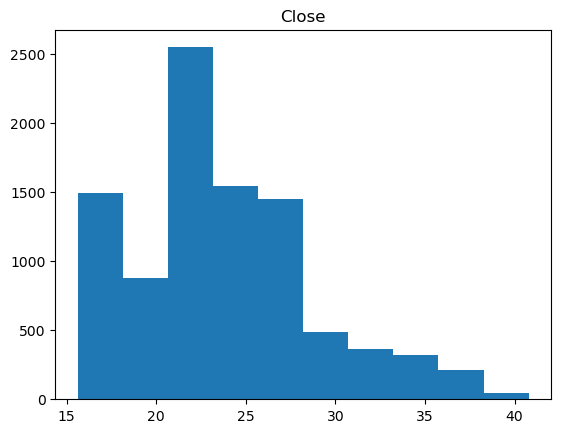

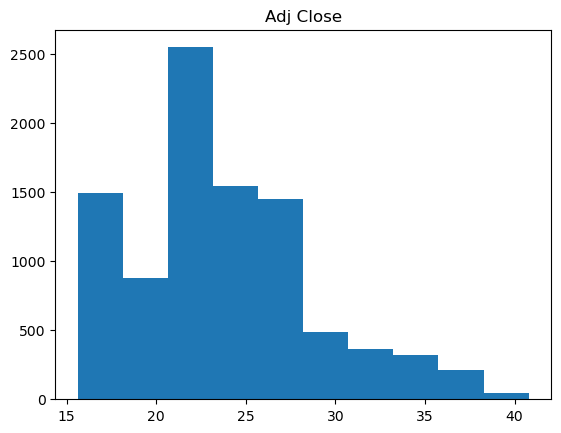

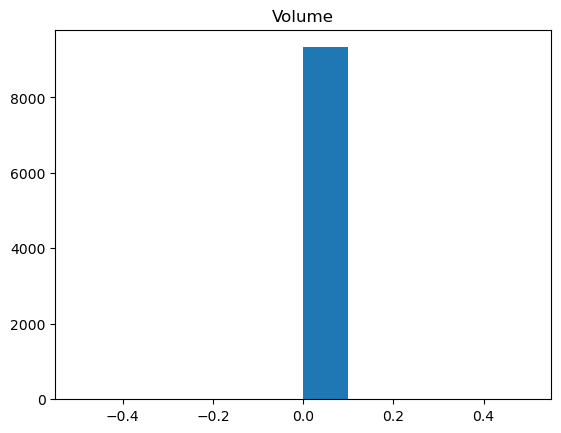

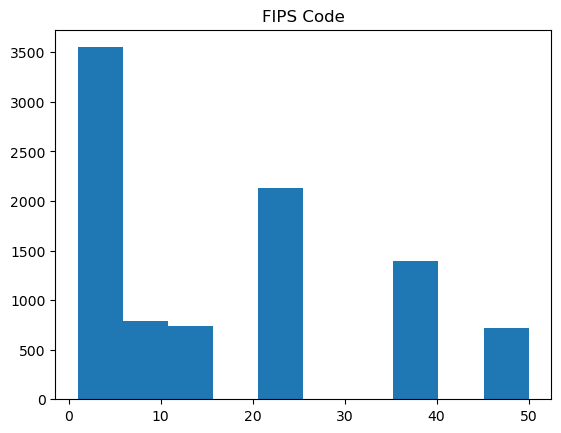

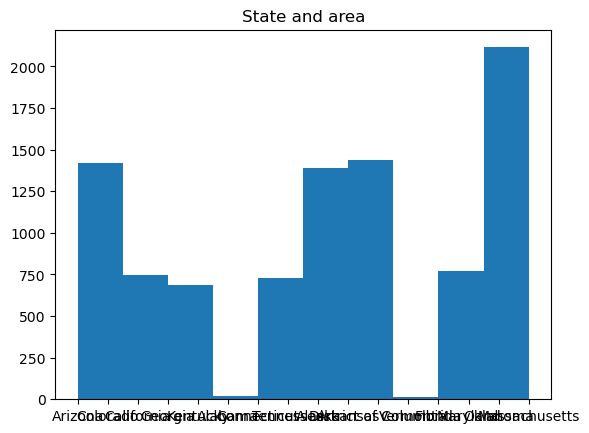

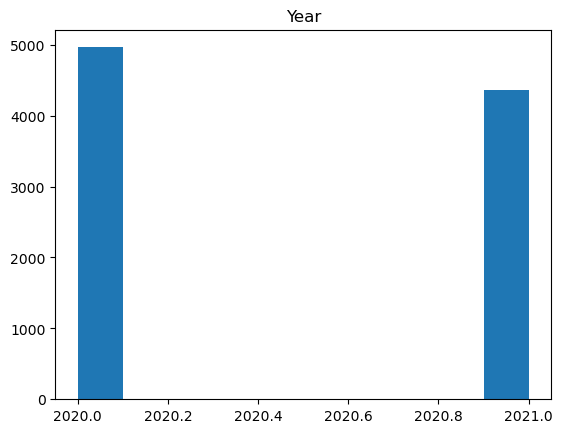

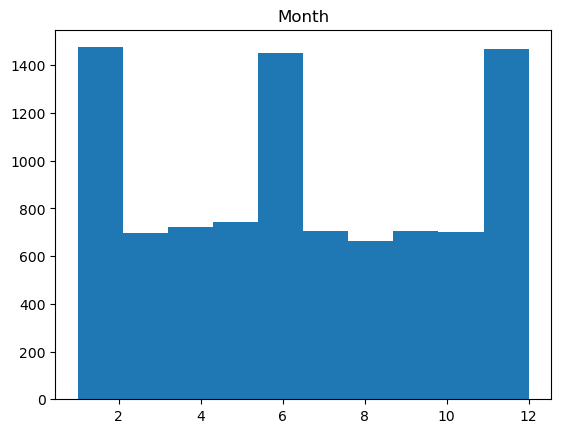

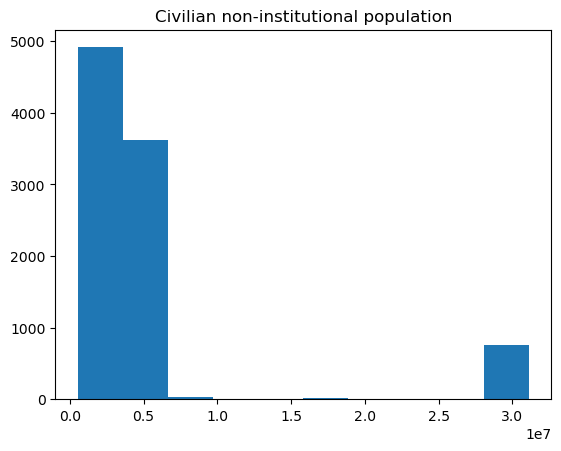

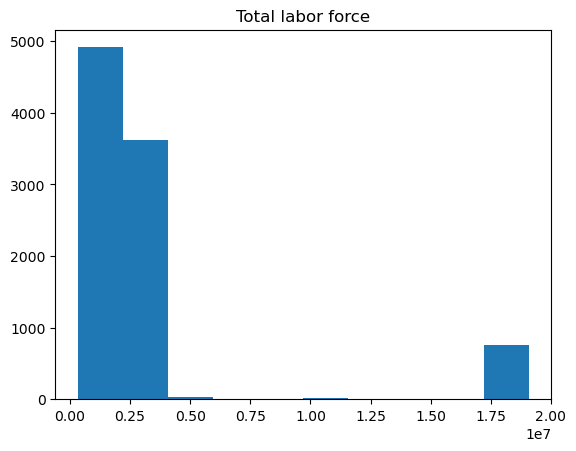

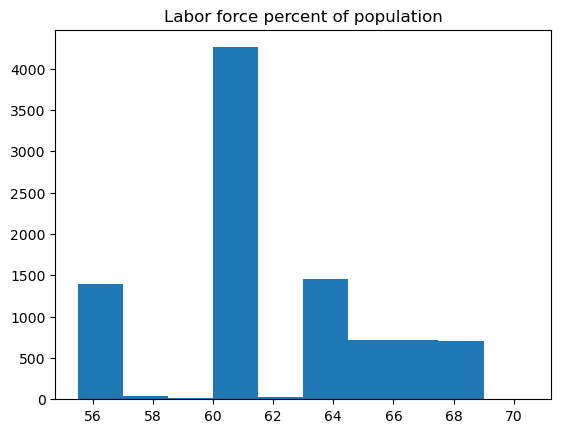

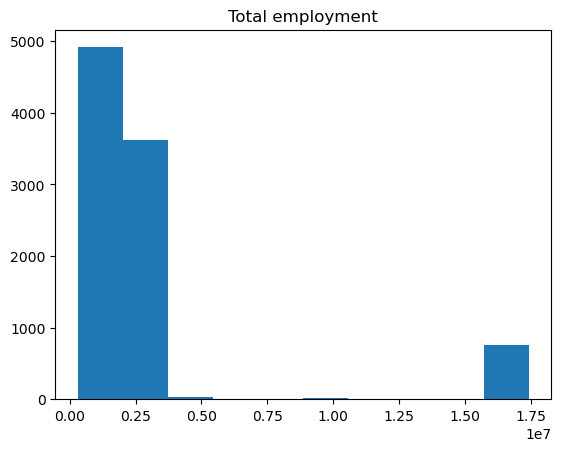

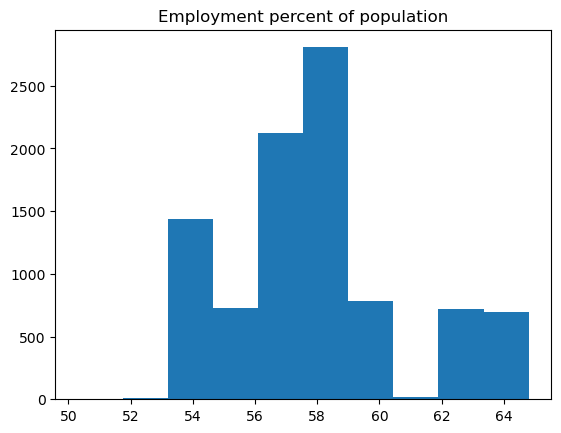

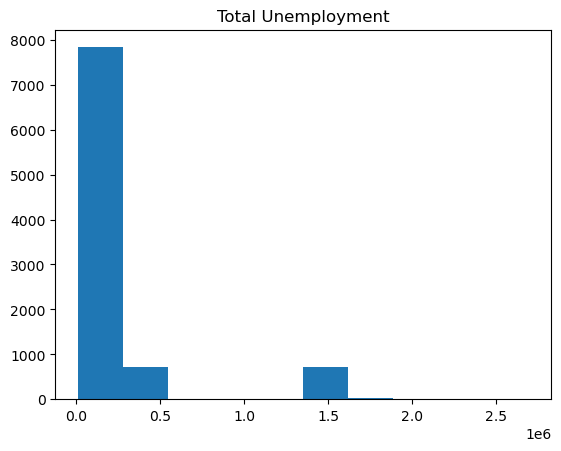

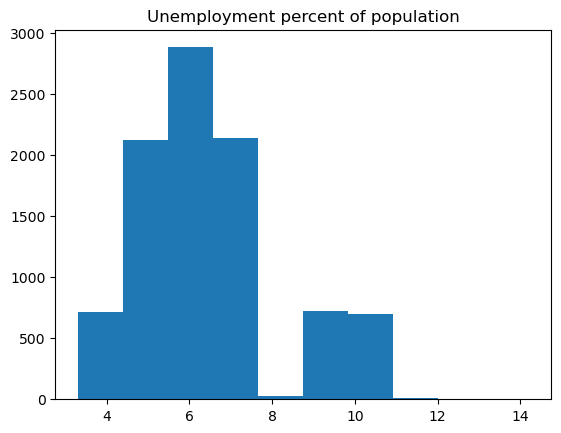

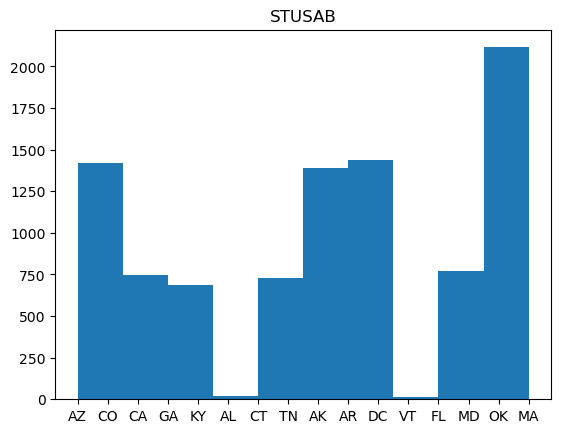

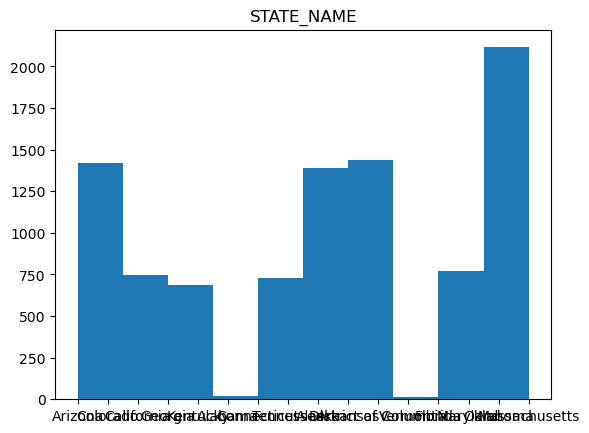

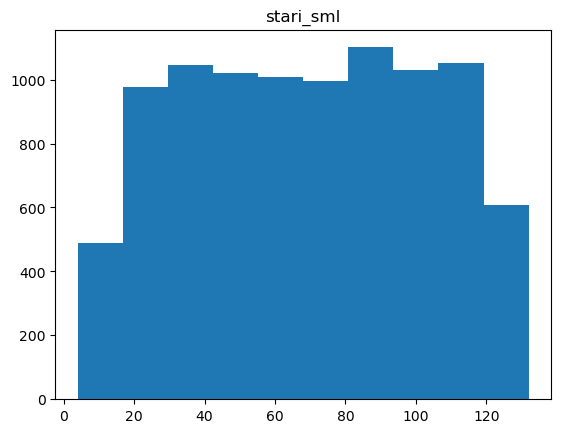

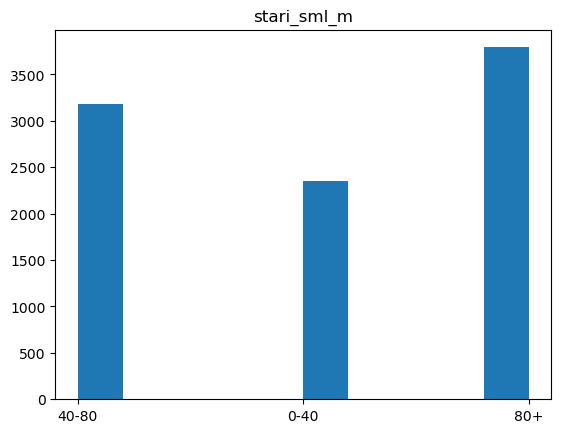

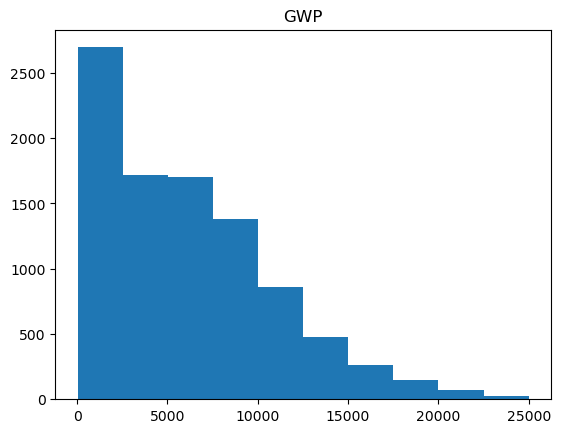

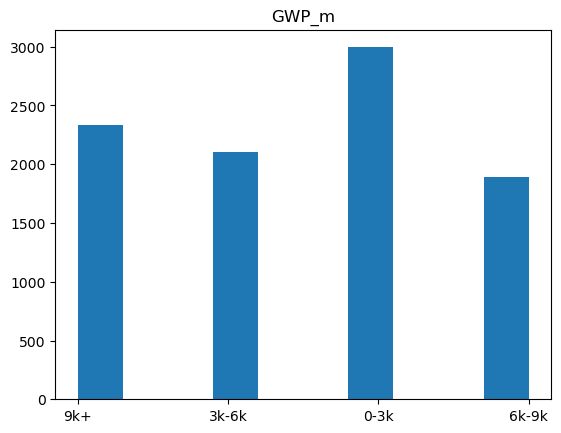

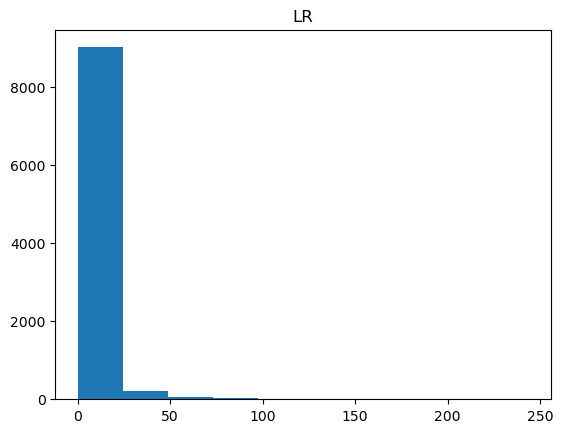

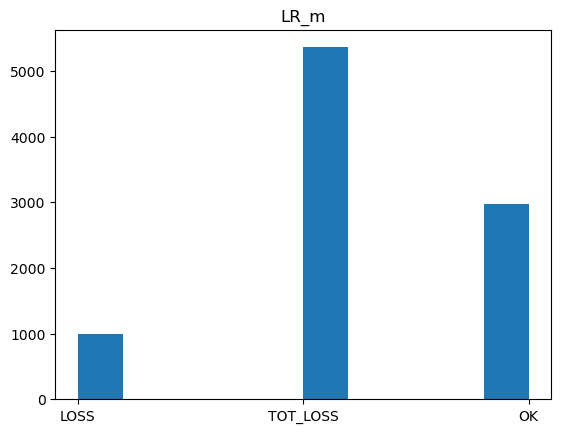

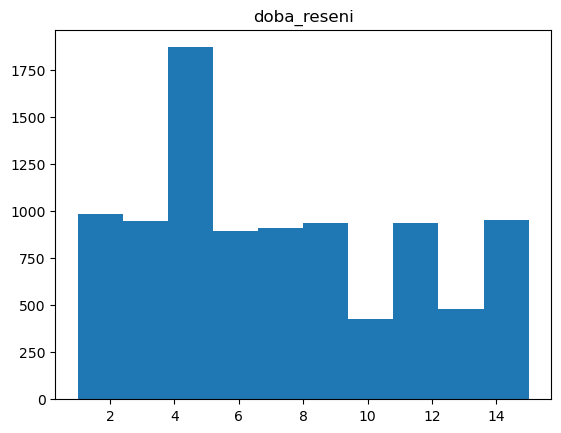

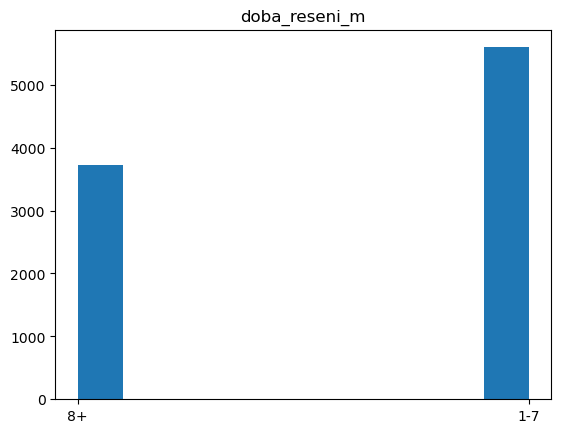

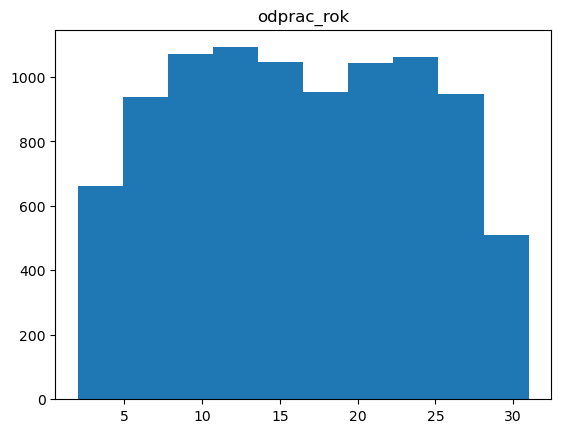

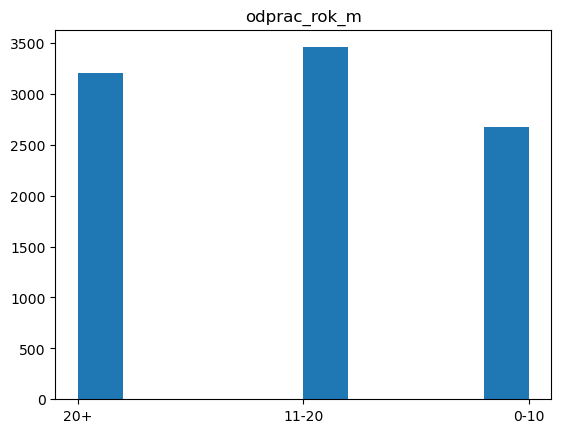

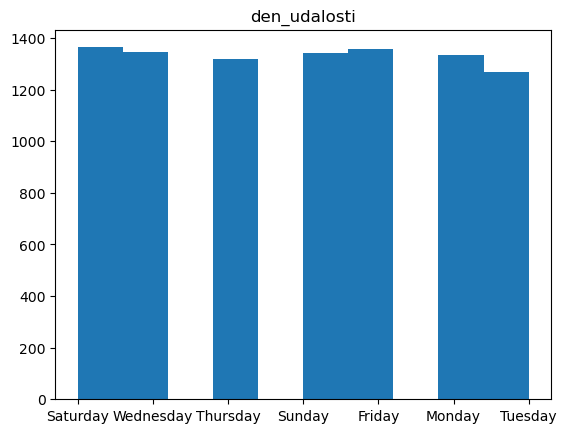

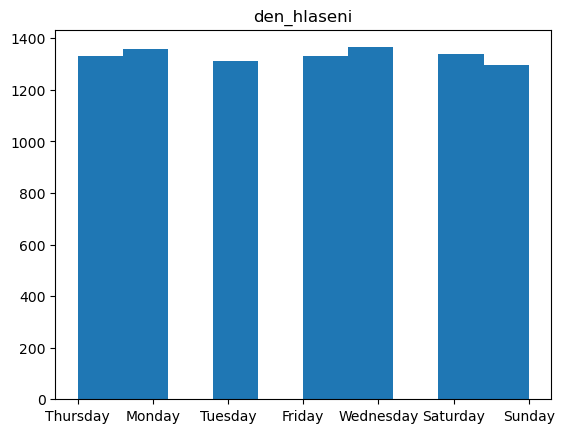

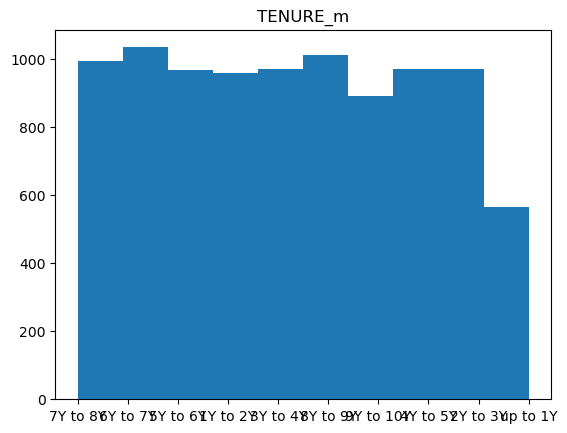

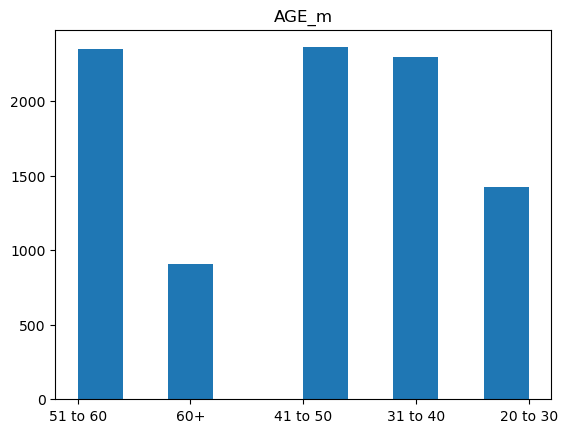

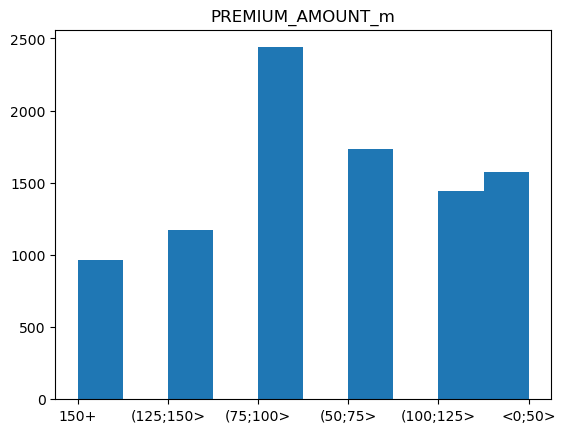

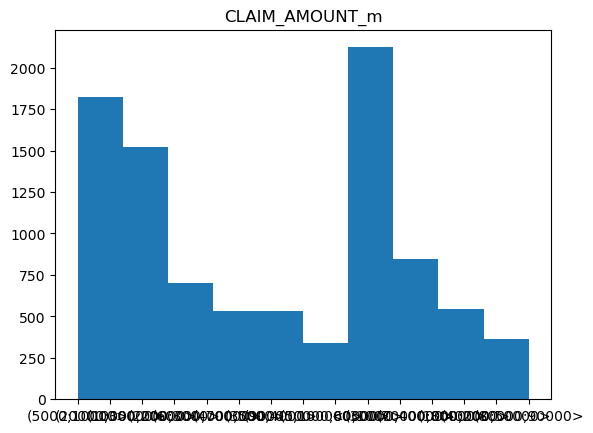

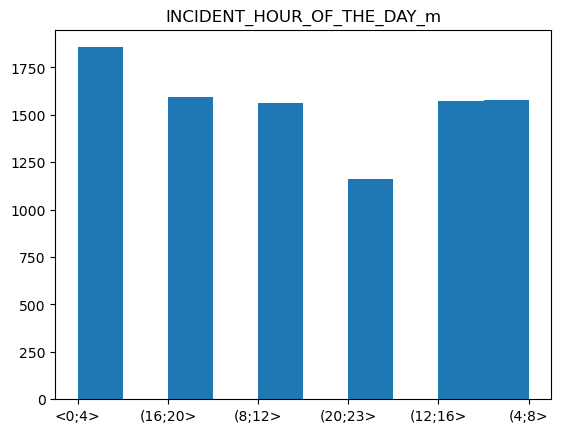

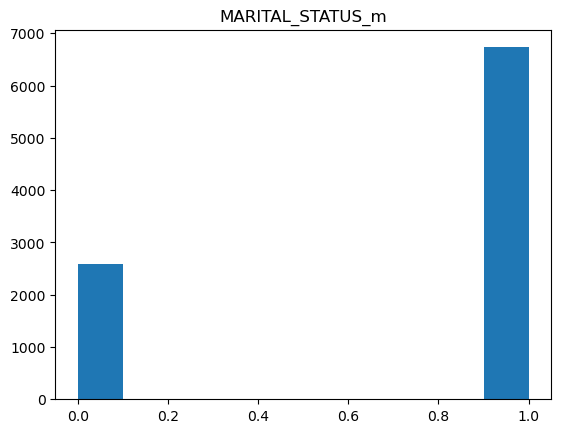

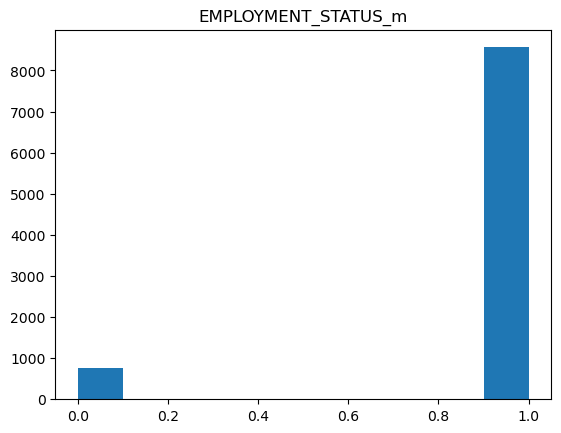

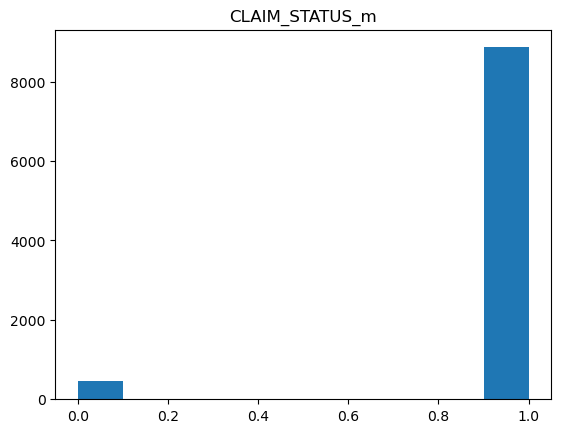

In [63]:
#Histogramy pro sloupce ktere ma smysl ponechat a pracovat s nimi
cols_to_plot = ['INSURANCE_TYPE', 'PREMIUM_AMOUNT', 'CLAIM_AMOUNT', 'CITY_x', 'STATE_x', 'MARITAL_STATUS', 'AGE', 'TENURE', 'EMPLOYMENT_STATUS',
                'NO_OF_FAMILY_MEMBERS', 'RISK_SEGMENTATION','HOUSE_TYPE', 'SOCIAL_CLASS', 'CUSTOMER_EDUCATION_LEVEL',
                'CLAIM_STATUS', 'INCIDENT_SEVERITY', 'AUTHORITY_CONTACTED', 'ANY_INJURY', 'POLICE_REPORT_AVAILABLE', 'INCIDENT_STATE', 'INCIDENT_CITY',
                'INCIDENT_HOUR_OF_THE_DAY', 'CITY_y', 'STATE_y',
                'Cases_covid',
                'CPIAUCSL', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'FIPS Code', 'State and area', 
                'Year', 'Month', 'Civilian non-institutional population', 'Total labor force', 'Labor force percent of population', 'Total employment',
                 'Employment percent of population', 'Total Unemployment', 'Unemployment percent of population', 'STUSAB', 'STATE_NAME',
                 'stari_sml', 'stari_sml_m', 'GWP', 'GWP_m', 'LR', 'LR_m', 'doba_reseni', 'doba_reseni_m', 'odprac_rok', 'odprac_rok_m', 'den_udalosti', 'den_hlaseni',
                 'TENURE_m',
                 'AGE_m', 'PREMIUM_AMOUNT_m', 'CLAIM_AMOUNT_m', 'INCIDENT_HOUR_OF_THE_DAY_m', 'MARITAL_STATUS_m', 'EMPLOYMENT_STATUS_m', 'CLAIM_STATUS_m']
# Krok 2: Vytvorim for cyklus ktery projde nazvy sloupcu
for i in range(len(cols_to_plot)):              #od i do poctu nazvu v promenne cols_to_plot
    plt.hist(data_clean[cols_to_plot[i]], )
    plt.title(cols_to_plot[i])
    plt.show()

# CF Miner

In [64]:
CF_incident_severity = cleverminer(df=data_clean,target='INCIDENT_SEVERITY',proc='CFMiner',
               quantifiers= {
                    #'S_up' : 2,
           #         'S_down' : 2,
                    'RelMax' : 0.50, 
                    'Base':105
                    },
               cond ={
                    'attributes':[
                        {'name': 'MARITAL_STATUS', 'type': 'subset', 'minlen': 1, 'maxlen': 1},
                        {'name': 'AGE_m', 'type': 'subset', 'minlen': 1, 'maxlen': 1},
                        {'name': 'EMPLOYMENT_STATUS', 'type': 'subset', 'minlen': 1, 'maxlen': 1},
                        {'name': 'INSURANCE_TYPE', 'type': 'subset', 'minlen': 1, 'maxlen': 1},
                        {'name': 'TENURE_m', 'type': 'subset', 'minlen': 1, 'maxlen': 1},
                        {'name': 'POLICE_REPORT_AVAILABLE', 'type': 'subset', 'minlen': 1, 'maxlen': 1},
                        {'name': 'ANY_INJURY', 'type': 'subset', 'minlen': 1, 'maxlen': 1},
                        {'name': 'AUTHORITY_CONTACTED', 'type': 'subset', 'minlen': 1, 'maxlen': 1},
                        {'name': 'SOCIAL_CLASS', 'type': 'subset', 'minlen': 1, 'maxlen': 1},
                        {'name': 'CUSTOMER_EDUCATION_LEVEL', 'type': 'subset', 'minlen': 1, 'maxlen': 1},
                        {'name': 'INCIDENT_STATE', 'type': 'subset', 'minlen': 1, 'maxlen': 1},
                        {'name': 'stari_sml_m', 'type': 'subset', 'minlen': 1, 'maxlen': 1},
                        {'name': 'GWP_m', 'type': 'subset', 'minlen': 1, 'maxlen': 1},
                        {'name': 'den_udalosti', 'type': 'subset', 'minlen': 1, 'maxlen': 1}
                    ], 'minlen':1, 'maxlen':6, 'type':'con'}
               )

Cleverminer version 1.0.2. Note: This version is for personal and educational use only. If you need PRO version (support, fixing structures for compactibility in future versions for production deployment, additional development, licensing of commercial use of subroutines used), feel free to ask authors. Most of these functionalities are maintained in best-effort, as soon as this project is at given conditions for free use and rapid development is needed, they cannot be guaranteed.
Starting data preparation ...
Encoding columns into bit-form...
Encoding columns into bit-form...done
Data preparation finished.
Will go for  CFMiner
Starting to mine rules.
Done. Total verifications : 35434, rules 7,control number:0, times: prep 7.05285120010376, processing 23.051235914230347


In [65]:
CF_incident_severity.print_rulelist()
#clm.print_rule(1)
# Existuji atributy pri kterych je relativni cestnost alespon jedne ze kategorii incident severity (Minor Loss, Major Loss, Total Loss) minimalne 50% 




List of rules:
RULEID BASE  S_UP  S_DOWN Condition
     1   166     1     1 MARITAL_STATUS(Y) & AGE_m(31 to 40) & EMPLOYMENT_STATUS(Y) & POLICE_REPORT_AVAILABLE(1) & SOCIAL_CLASS(MI) & GWP_m(0-3k)
     2   105     0     2 MARITAL_STATUS(Y) & AGE_m(31 to 40) & ANY_INJURY(0) & stari_sml_m(0-40) & GWP_m(0-3k)
     3   107     0     1 AGE_m(51 to 60) & ANY_INJURY(1) & AUTHORITY_CONTACTED(Ambulance) & den_udalosti(Wednesday)
     4   110     1     1 EMPLOYMENT_STATUS(Y) & POLICE_REPORT_AVAILABLE(1) & ANY_INJURY(1) & AUTHORITY_CONTACTED(None) & stari_sml_m(40-80) & GWP_m(3k-6k)
     5   128     1     1 EMPLOYMENT_STATUS(Y) & ANY_INJURY(0) & AUTHORITY_CONTACTED(Ambulance) & SOCIAL_CLASS(MI) & CUSTOMER_EDUCATION_LEVEL(High School)
     6   115     2     0 EMPLOYMENT_STATUS(Y) & ANY_INJURY(1) & AUTHORITY_CONTACTED(Police) & stari_sml_m(0-40) & GWP_m(3k-6k)
     7   136     1     1 ANY_INJURY(0) & AUTHORITY_CONTACTED(Ambulance) & SOCIAL_CLASS(MI) & CUSTOMER_EDUCATION_LEVEL(High School)



In [66]:
CF_incident_severity.print_rule(1)



Rule id : 1

Base :   166  Relative base : 0.018  Steps UP (consecutive) :     1  Steps DOWN (consecutive) :     1  Steps UP (any) :     1  Steps DOWN (any) :     1  Histogram maximum :    84  Histogram minimum :    38  Histogram relative maximum : 0.506 Histogram relative minimum : 0.229

Condition  : MARITAL_STATUS(Y) & AGE_m(31 to 40) & EMPLOYMENT_STATUS(Y) & POLICE_REPORT_AVAILABLE(1) & SOCIAL_CLASS(MI) & GWP_m(0-3k)

Histogram [84, 38, 44]



In [67]:
CF_incident_severity.print_rule(5)



Rule id : 5

Base :   128  Relative base : 0.014  Steps UP (consecutive) :     1  Steps DOWN (consecutive) :     1  Steps UP (any) :     1  Steps DOWN (any) :     1  Histogram maximum :    65  Histogram minimum :    29  Histogram relative maximum : 0.508 Histogram relative minimum : 0.227

Condition  : EMPLOYMENT_STATUS(Y) & ANY_INJURY(0) & AUTHORITY_CONTACTED(Ambulance) & SOCIAL_CLASS(MI) & CUSTOMER_EDUCATION_LEVEL(High School)

Histogram [29, 65, 34]



In [68]:
CF_incident_severity.print_rule(7)



Rule id : 7

Base :   136  Relative base : 0.015  Steps UP (consecutive) :     1  Steps DOWN (consecutive) :     1  Steps UP (any) :     1  Steps DOWN (any) :     1  Histogram maximum :    68  Histogram minimum :    32  Histogram relative maximum : 0.500 Histogram relative minimum : 0.235

Condition  : ANY_INJURY(0) & AUTHORITY_CONTACTED(Ambulance) & SOCIAL_CLASS(MI) & CUSTOMER_EDUCATION_LEVEL(High School)

Histogram [32, 68, 36]



<BarContainer object of 3 artists>

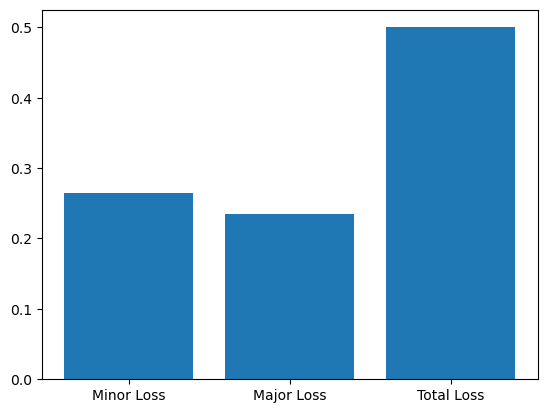

In [69]:
plot_data = [36, 32, 68]
axes = ['Minor Loss', 'Major Loss', 'Total Loss']
total_plot_data = np.array(plot_data).sum()
plot_data = plot_data/total_plot_data
plt.bar(axes, plot_data)

In [70]:
CF_weekday = cleverminer(df=data_clean[data_clean['INSURANCE_TYPE'] == 'Motor'],target='den_udalosti',proc='CFMiner',
               quantifiers= {
           #         'S_up' : 3,
           #         'S_down' : 2,
                    'RelMax' : 0.25,
           #         'S_Any_Up' : 0,
           #         'S_Any_Down' : 0,
                    'Base':105
                    },
               cond ={
                    'attributes':[
                        {'name': 'MARITAL_STATUS', 'type': 'subset', 'minlen': 1, 'maxlen': 1},
                        {'name': 'AGE_m', 'type': 'subset', 'minlen': 1, 'maxlen': 1},
                        {'name': 'EMPLOYMENT_STATUS', 'type': 'subset', 'minlen': 1, 'maxlen': 1},
                       # {'name': 'INSURANCE_TYPE', 'type': 'subset', 'minlen': 1, 'maxlen': 1},
                        {'name': 'TENURE_m', 'type': 'subset', 'minlen': 1, 'maxlen': 1},
                        {'name': 'POLICE_REPORT_AVAILABLE', 'type': 'subset', 'minlen': 1, 'maxlen': 1},
                        {'name': 'ANY_INJURY', 'type': 'subset', 'minlen': 1, 'maxlen': 1},
                        {'name': 'AUTHORITY_CONTACTED', 'type': 'subset', 'minlen': 1, 'maxlen': 1},
                        {'name': 'SOCIAL_CLASS', 'type': 'subset', 'minlen': 1, 'maxlen': 1},
                        {'name': 'CUSTOMER_EDUCATION_LEVEL', 'type': 'subset', 'minlen': 1, 'maxlen': 1},
                        {'name': 'INCIDENT_STATE', 'type': 'subset', 'minlen': 1, 'maxlen': 1},
                        {'name': 'stari_sml_m', 'type': 'subset', 'minlen': 1, 'maxlen': 1},
                        {'name': 'GWP_m', 'type': 'subset', 'minlen': 1, 'maxlen': 1}
                    ], 'minlen':1, 'maxlen':6, 'type':'con'}
               )

Cleverminer version 1.0.2. Note: This version is for personal and educational use only. If you need PRO version (support, fixing structures for compactibility in future versions for production deployment, additional development, licensing of commercial use of subroutines used), feel free to ask authors. Most of these functionalities are maintained in best-effort, as soon as this project is at given conditions for free use and rapid development is needed, they cannot be guaranteed.
Starting data preparation ...
Encoding columns into bit-form...


/Users/danielmalinovsky/opt/anaconda3/envs/vseML/lib/python3.9/site-packages/cleverminer/cleverminer.py:145: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  OOOOO00OO0O000O0O [O000OOO0000OOOO0O ]=OOOOO00OO0O000O0O [O000OOO0000OOOO0O ].apply (str )#line:209


Encoding columns into bit-form...done
Data preparation finished.
Will go for  CFMiner
Starting to mine rules.
Done. Total verifications : 1039, rules 3,control number:0, times: prep 0.9027881622314453, processing 0.4197678565979004


In [71]:
CF_weekday.print_rulelist()


List of rules:
RULEID BASE  S_UP  S_DOWN Condition
     1   108     2     2 MARITAL_STATUS(Y) & AGE_m(51 to 60) & EMPLOYMENT_STATUS(Y) & stari_sml_m(80+)
     2   124     2     2 EMPLOYMENT_STATUS(Y) & ANY_INJURY(0) & GWP_m(3k-6k)
     3   127     2     2 ANY_INJURY(0) & GWP_m(3k-6k)



In [72]:
CF_weekday.print_rule(1)



Rule id : 1

Base :   108  Relative base : 0.073  Steps UP (consecutive) :     2  Steps DOWN (consecutive) :     2  Steps UP (any) :     3  Steps DOWN (any) :     3  Histogram maximum :    27  Histogram minimum :    10  Histogram relative maximum : 0.250 Histogram relative minimum : 0.093

Condition  : MARITAL_STATUS(Y) & AGE_m(51 to 60) & EMPLOYMENT_STATUS(Y) & stari_sml_m(80+)

Histogram [10, 14, 27, 11, 18, 15, 13]



In [73]:
CF_weekday.print_rule(2)



Rule id : 2

Base :   124  Relative base : 0.084  Steps UP (consecutive) :     2  Steps DOWN (consecutive) :     2  Steps UP (any) :     3  Steps DOWN (any) :     3  Histogram maximum :    31  Histogram minimum :    11  Histogram relative maximum : 0.250 Histogram relative minimum : 0.089

Condition  : EMPLOYMENT_STATUS(Y) & ANY_INJURY(0) & GWP_m(3k-6k)

Histogram [16, 11, 31, 15, 13, 18, 20]



In [74]:
CF_weekday.print_rule(3)



Rule id : 3

Base :   127  Relative base : 0.086  Steps UP (consecutive) :     2  Steps DOWN (consecutive) :     2  Steps UP (any) :     3  Steps DOWN (any) :     3  Histogram maximum :    32  Histogram minimum :    11  Histogram relative maximum : 0.252 Histogram relative minimum : 0.087

Condition  : ANY_INJURY(0) & GWP_m(3k-6k)

Histogram [16, 11, 32, 15, 13, 18, 22]



<AxesSubplot:>

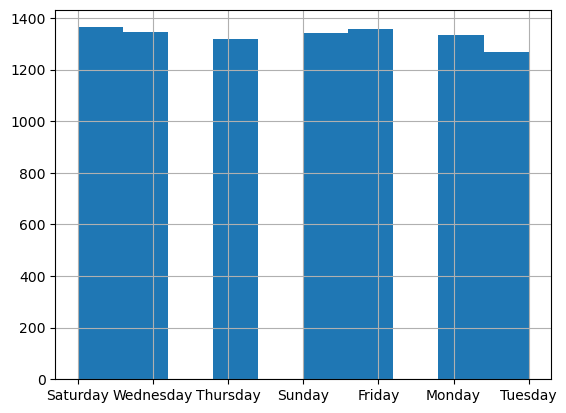

In [75]:
data_clean['den_udalosti'].hist()

<BarContainer object of 7 artists>

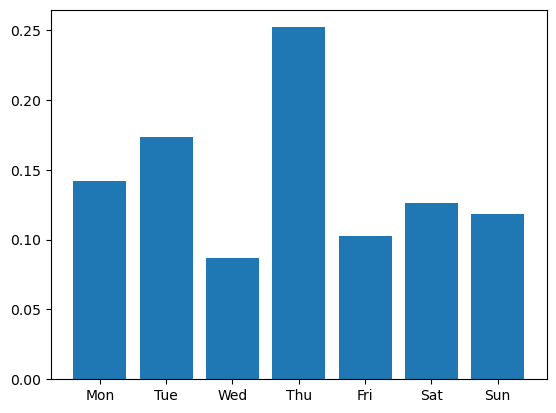

In [76]:
plot_data = [18, 22, 11, 32, 13, 16, 15]
axes = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
total_plot_data = np.array(plot_data).sum()
plot_data = plot_data/total_plot_data
plt.bar(axes, plot_data)

# FT4 Miner

In [77]:
ft4_miner_1 = cleverminer(df=data_clean,proc='4ftMiner',
               quantifiers= {'conf':0.9, 'Base':100}, 
               ante ={
                    'attributes':[
                        {'name': 'INSURANCE_TYPE', 'type': 'subset', 'minlen': 1, 'maxlen': 1},
                        {'name': 'AGE_m', 'type': 'subset', 'minlen': 1, 'maxlen': 1},
                        {'name': 'TENURE_m', 'type': 'subset', 'minlen': 1, 'maxlen': 1},
                        {'name': 'EMPLOYMENT_STATUS_m', 'type': 'subset', 'minlen': 1, 'maxlen': 1},
                        {'name': 'RISK_SEGMENTATION', 'type': 'subset', 'minlen': 1, 'maxlen': 1},
                        {'name': 'HOUSE_TYPE', 'type': 'subset', 'minlen': 1, 'maxlen': 1},
                        {'name': 'SOCIAL_CLASS', 'type': 'subset', 'minlen': 1, 'maxlen': 1},
                        {'name': 'CUSTOMER_EDUCATION_LEVEL', 'type': 'subset', 'minlen': 1, 'maxlen': 1},
                        {'name': 'INCIDENT_SEVERITY', 'type': 'seq', 'minlen': 1, 'maxlen': 2},
                        {'name': 'ANY_INJURY', 'type': 'subset', 'minlen': 1, 'maxlen': 1},
                        {'name': 'INCIDENT_STATE', 'type': 'subset', 'minlen': 1, 'maxlen': 1},
                        {'name': 'stari_sml_m', 'type': 'subset', 'minlen': 1, 'maxlen': 1},
                                               {'name': 'doba_reseni_m', 'type': 'subset', 'minlen': 1, 'maxlen': 1},
                        {'name': 'odprac_rok_m', 'type': 'subset', 'minlen': 1, 'maxlen': 1},
                        {'name': 'den_udalosti', 'type': 'subset', 'minlen': 1, 'maxlen': 1}
                    ], 'minlen':1, 'maxlen':3, 'type':'con'},
               succ ={
                    'attributes':[
                        {'name': 'LR_m', 'type': 'one', 'value': 'OK'}
                    ], 'minlen':1, 'maxlen':1, 'type':'con'}
               )

ft4_miner_1.print_summary()

Cleverminer version 1.0.2. Note: This version is for personal and educational use only. If you need PRO version (support, fixing structures for compactibility in future versions for production deployment, additional development, licensing of commercial use of subroutines used), feel free to ask authors. Most of these functionalities are maintained in best-effort, as soon as this project is at given conditions for free use and rapid development is needed, they cannot be guaranteed.
Starting data preparation ...
Encoding columns into bit-form...
Encoding columns into bit-form...done
Data preparation finished.
Will go for  4ftMiner
Starting to mine rules.
Done. Total verifications : 4902, rules 15,control number:0, times: prep 7.176501989364624, processing 3.155330181121826

CleverMiner task processing summary:

Task type : 4ftMiner
Number of verifications : 4902
Number of rules : 15
Total time needed : 00h 00m 10s
Time of data preparation : 00h 00m 07s
Time of rule mining : 00h 00m 03s



In [78]:
ft4_miner_1.print_rulelist()


List of rules:
RULEID BASE  CONF  AAD    Rule
     1   151 0.938 +1.944 INSURANCE_TYPE(Travel) & AGE_m(41 to 50) & stari_sml_m(80+) => LR_m(OK) | ---
     2   234 0.925 +1.903 INSURANCE_TYPE(Travel) & RISK_SEGMENTATION(M) & stari_sml_m(80+) => LR_m(OK) | ---
     3   193 0.906 +1.844 INSURANCE_TYPE(Travel) & HOUSE_TYPE(Mortgage) & stari_sml_m(80+) => LR_m(OK) | ---
     4   159 0.930 +1.918 INSURANCE_TYPE(Travel) & HOUSE_TYPE(Own) & stari_sml_m(80+) => LR_m(OK) | ---
     5   121 0.924 +1.899 INSURANCE_TYPE(Travel) & SOCIAL_CLASS(HI) & stari_sml_m(80+) => LR_m(OK) | ---
     6   151 0.921 +1.890 INSURANCE_TYPE(Travel) & SOCIAL_CLASS(LI) & stari_sml_m(80+) => LR_m(OK) | ---
     7   190 0.913 +1.867 INSURANCE_TYPE(Travel) & INCIDENT_SEVERITY(Minor Loss) & stari_sml_m(80+) => LR_m(OK) | ---
     8   372 0.916 +1.876 INSURANCE_TYPE(Travel) & INCIDENT_SEVERITY(Minor Loss Total Loss) & stari_sml_m(80+) => LR_m(OK) | ---
     9   182 0.919 +1.885 INSURANCE_TYPE(Travel) & INCIDENT_SEVERITY(T

In [79]:
ft4_miner_1.print_rule(1)
# 



Rule id : 1

Base :   151  Relative base : 0.016  CONF : 0.938  AAD : +1.944  BAD : -1.944

Cedents:
  antecedent : INSURANCE_TYPE(Travel) & AGE_m(41 to 50) & stari_sml_m(80+)
  succcedent : LR_m(OK)
  condition  : ---

Fourfold table
    |  S  |  ¬S |
----|-----|-----|
 A  |  151|   10|
----|-----|-----|
¬A  | 2821| 6346|
----|-----|-----|



In [80]:
ft4_miner_1.print_rule(12)
# 



Rule id : 12

Base :   541  Relative base : 0.058  CONF : 0.905  AAD : +1.839  BAD : -1.839

Cedents:
  antecedent : INSURANCE_TYPE(Travel) & stari_sml_m(80+)
  succcedent : LR_m(OK)
  condition  : ---

Fourfold table
    |  S  |  ¬S |
----|-----|-----|
 A  |  541|   57|
----|-----|-----|
¬A  | 2431| 6299|
----|-----|-----|



In [81]:
clm_4FT_miner_2 = cleverminer(df=data_clean[data_clean['INSURANCE_TYPE'] == 'Travel'],proc='4ftMiner',
               quantifiers= {'aad':0.25, 'RelBase':0.05},
               ante ={
                    'attributes':[
                        {'name': 'AGE_m', 'type': 'seq', 'minlen': 1, 'maxlen': 2},
                        {'name': 'EMPLOYMENT_STATUS', 'type': 'subset', 'minlen': 1, 'maxlen': 1},
                        {'name': 'INSURANCE_TYPE', 'type': 'subset', 'minlen': 1, 'maxlen': 1},
                        {'name': 'TENURE_m', 'type': 'seq', 'minlen': 1, 'maxlen': 2},
                        {'name': 'POLICE_REPORT_AVAILABLE', 'type': 'subset', 'minlen': 1, 'maxlen': 1},
                        {'name': 'ANY_INJURY', 'type': 'subset', 'minlen': 1, 'maxlen': 1},
                        {'name': 'AUTHORITY_CONTACTED', 'type': 'subset', 'minlen': 1, 'maxlen': 1},
                        {'name': 'SOCIAL_CLASS', 'type': 'subset', 'minlen': 1, 'maxlen': 1},
                        {'name': 'CUSTOMER_EDUCATION_LEVEL', 'type': 'subset', 'minlen': 1, 'maxlen': 1},
                        {'name': 'INCIDENT_STATE', 'type': 'subset', 'minlen': 1, 'maxlen': 1},
                        {'name': 'stari_sml_m', 'type': 'seq', 'minlen': 1, 'maxlen': 2},
                        {'name': 'GWP_m', 'type': 'subset', 'minlen': 1, 'maxlen': 1} #proměnná, měni mkterej sloupec chci v mineru
                    ], 'minlen':3, 'maxlen':5, 'type':'con'},
               succ ={
                    'attributes':[
                        {'name': 'PREMIUM_AMOUNT_m', 'type':'seq', 'minlen': 1, 'maxlen': 2},
                        {'name': 'INCIDENT_SEVERITY', 'type': 'one', 'value': 'Total Loss'} #proměnná, měni mkterej sloupec chci v mineru
                    ], 'minlen':2, 'maxlen':2, 'type':'con'},
               )

clm_4FT_miner_2.print_summary()

Cleverminer version 1.0.2. Note: This version is for personal and educational use only. If you need PRO version (support, fixing structures for compactibility in future versions for production deployment, additional development, licensing of commercial use of subroutines used), feel free to ask authors. Most of these functionalities are maintained in best-effort, as soon as this project is at given conditions for free use and rapid development is needed, they cannot be guaranteed.
Starting data preparation ...
Encoding columns into bit-form...


/Users/danielmalinovsky/opt/anaconda3/envs/vseML/lib/python3.9/site-packages/cleverminer/cleverminer.py:145: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  OOOOO00OO0O000O0O [O000OOO0000OOOO0O ]=OOOOO00OO0O000O0O [O000OOO0000OOOO0O ].apply (str )#line:209


Encoding columns into bit-form...done
Data preparation finished.
Will go for  4ftMiner
Starting to mine rules.
Done. Total verifications : 973, rules 24,control number:0, times: prep 0.950531005859375, processing 4.2409422397613525

CleverMiner task processing summary:

Task type : 4ftMiner
Number of verifications : 973
Number of rules : 24
Total time needed : 00h 00m 05s
Time of data preparation : 00h 00m 00s
Time of rule mining : 00h 00m 04s



In [82]:
clm_4FT_miner_2.print_rulelist()


List of rules:
RULEID BASE  CONF  AAD    Rule
     1    83 0.215 +0.281 AGE_m(51 to 60 60+) & INSURANCE_TYPE(Travel) & POLICE_REPORT_AVAILABLE(1) => PREMIUM_AMOUNT_m((75;100>) & INCIDENT_SEVERITY(Total Loss) | ---
     2    83 0.215 +0.281 AGE_m(51 to 60 60+) & INSURANCE_TYPE(Travel) & POLICE_REPORT_AVAILABLE(1) => PREMIUM_AMOUNT_m((75;100> (100;125>) & INCIDENT_SEVERITY(Total Loss) | ---
     3    81 0.221 +0.289 EMPLOYMENT_STATUS(Y) & INSURANCE_TYPE(Travel) & stari_sml_m(0-40) & GWP_m(0-3k) => PREMIUM_AMOUNT_m(<0;50> (50;75>) & INCIDENT_SEVERITY(Total Loss) | ---
     4    81 0.221 +0.289 EMPLOYMENT_STATUS(Y) & INSURANCE_TYPE(Travel) & stari_sml_m(0-40) & GWP_m(0-3k) => PREMIUM_AMOUNT_m((50;75>) & INCIDENT_SEVERITY(Total Loss) | ---
     5    92 0.227 +0.323 EMPLOYMENT_STATUS(Y) & INSURANCE_TYPE(Travel) & stari_sml_m(0-40 40-80) & GWP_m(0-3k) => PREMIUM_AMOUNT_m(<0;50> (50;75>) & INCIDENT_SEVERITY(Total Loss) | ---
     6    92 0.227 +0.323 EMPLOYMENT_STATUS(Y) & INSURANCE_TYPE(Trav

In [83]:
clm_4FT_miner_2.print_rule(2)



Rule id : 2

Base :    83  Relative base : 0.053  CONF : 0.215  AAD : +0.281  BAD : -0.281

Cedents:
  antecedent : AGE_m(51 to 60 60+) & INSURANCE_TYPE(Travel) & POLICE_REPORT_AVAILABLE(1)
  succcedent : PREMIUM_AMOUNT_m((75;100> (100;125>) & INCIDENT_SEVERITY(Total Loss)
  condition  : ---

Fourfold table
    |  S  |  ¬S |
----|-----|-----|
 A  |   83|  303|
----|-----|-----|
¬A  |  178|  991|
----|-----|-----|



# SD4FT miner

In [84]:
SD4FT_miner_1 = cleverminer(df=data_clean,proc='SD4ftMiner',
               quantifiers= {'Base1':20, 'Base2':20, 'Ratioconf' : 2.0},
               ante ={
                    'attributes':[
                        {'name': 'stari_sml_m', 'type': 'seq', 'minlen': 1, 'maxlen': 2} #proměnná, měni mkterej sloupec chci v mineru
                    ], 'minlen':1, 'maxlen':2, 'type':'con'},
               succ ={
                    'attributes':[
                        {'name': 'PREMIUM_AMOUNT_m', 'type': 'subset', 'minlen': 1, 'maxlen': 1} #proměnná, měni mkterej sloupec chci v mineru
                    ], 'minlen':1, 'maxlen':1, 'type':'con'},
               frst ={
                    'attributes':[
                        {'name': 'INCIDENT_STATE', 'type': 'subset', 'minlen': 1, 'maxlen': 1}, #proměnná, měni mkterej sloupec chci v mineru
                    ], 'minlen':1, 'maxlen':2, 'type':'con'},
               scnd ={
                    'attributes':[
                        {'name': 'INCIDENT_STATE', 'type': 'subset', 'minlen': 1, 'maxlen': 1}, #proměnná, měni mkterej sloupec chci v mineru
                    ], 'minlen':1, 'maxlen':1, 'type':'con'}
               )

SD4FT_miner_1.print_summary()

Cleverminer version 1.0.2. Note: This version is for personal and educational use only. If you need PRO version (support, fixing structures for compactibility in future versions for production deployment, additional development, licensing of commercial use of subroutines used), feel free to ask authors. Most of these functionalities are maintained in best-effort, as soon as this project is at given conditions for free use and rapid development is needed, they cannot be guaranteed.
Starting data preparation ...
Encoding columns into bit-form...
Encoding columns into bit-form...done
Data preparation finished.
Will go for  SD4ftMiner
Starting to mine rules.
Done. Total verifications : 7680, rules 3,control number:0, times: prep 7.408520936965942, processing 2.3824338912963867

CleverMiner task processing summary:

Task type : SD4ftMiner
Number of verifications : 7680
Number of rules : 3
Total time needed : 00h 00m 09s
Time of data preparation : 00h 00m 07s
Time of rule mining : 00h 00m 02

In [85]:
SD4FT_miner_1.print_rulelist()


List of rules:
RULEID BASE1 BASE2 RatioConf DeltaConf Rule
     1    45    24    2.144    +0.128  stari_sml_m(80+) => PREMIUM_AMOUNT_m(<0;50>) | --- : INCIDENT_STATE(AK) x INCIDENT_STATE(DC)
     2    58    32    2.006    +0.135  stari_sml_m(80+) => PREMIUM_AMOUNT_m((50;75>) | --- : INCIDENT_STATE(DC) x INCIDENT_STATE(AL)
     3    73    33    2.190    +0.097  stari_sml_m(40-80 80+) => PREMIUM_AMOUNT_m((125;150>) | --- : INCIDENT_STATE(GA) x INCIDENT_STATE(DC)



In [86]:
SD4FT_miner_1.print_rule(1)



Rule id : 1

Base1 :    45 Base2 :    24  Relative base 1 : 0.005 Relative base 2 : 0.003 CONF1 : 0.239  CONF2 : +0.112  Delta Conf : +0.128 Ratio Conf : +2.144

Cedents:
  antecedent : stari_sml_m(80+)
  succcedent : PREMIUM_AMOUNT_m(<0;50>)
  condition  : ---
  first set  : INCIDENT_STATE(AK)
  second set : INCIDENT_STATE(DC)

Fourfold tables:
FRST|  S  |  ¬S |  SCND|  S  |  ¬S |
----|-----|-----|  ----|-----|-----| 
 A  |   45|  143|   A  |   24|  191|
----|-----|-----|  ----|-----|-----|
¬A  |   46|  258|  ¬A  |   57|  277|
----|-----|-----|  ----|-----|-----|



In [87]:
SD4FT_miner_1.print_rule(2)



Rule id : 2

Base1 :    58 Base2 :    32  Relative base 1 : 0.006 Relative base 2 : 0.003 CONF1 : 0.270  CONF2 : +0.134  Delta Conf : +0.135 Ratio Conf : +2.006

Cedents:
  antecedent : stari_sml_m(80+)
  succcedent : PREMIUM_AMOUNT_m((50;75>)
  condition  : ---
  first set  : INCIDENT_STATE(DC)
  second set : INCIDENT_STATE(AL)

Fourfold tables:
FRST|  S  |  ¬S |  SCND|  S  |  ¬S |
----|-----|-----|  ----|-----|-----| 
 A  |   58|  157|   A  |   32|  206|
----|-----|-----|  ----|-----|-----|
¬A  |   70|  264|  ¬A  |   62|  273|
----|-----|-----|  ----|-----|-----|



In [88]:
SD4FT_miner_2 = cleverminer(df=data_clean,proc='SD4ftMiner',
               quantifiers= {'Base1':20, 'Base2':20, 'Ratioconf' : 1.5},
               ante ={
                    'attributes':[
                        {'name': 'INCIDENT_HOUR_OF_THE_DAY', 'type': 'seq', 'minlen': 1, 'maxlen': 3},
                    ], 'minlen':1, 'maxlen':1, 'type':'con'},
               succ ={
                    'attributes':[
                        {'name': 'CLAIM_AMOUNT_m', 'type': 'subset', 'minlen': 1, 'maxlen': 1},
                    ], 'minlen':1, 'maxlen':1, 'type':'con'},
               frst ={
                    'attributes':[
                        {'name': 'AGE_m', 'type': 'subset', 'minlen': 1, 'maxlen': 1},
                    ], 'minlen':1, 'maxlen':1, 'type':'con'},
               scnd ={
                    'attributes':[
                        {'name': 'AGE_m', 'type': 'subset', 'minlen': 1, 'maxlen': 1},
                    ], 'minlen':1, 'maxlen':1, 'type':'con'}
               )

SD4FT_miner_2.print_summary()

Cleverminer version 1.0.2. Note: This version is for personal and educational use only. If you need PRO version (support, fixing structures for compactibility in future versions for production deployment, additional development, licensing of commercial use of subroutines used), feel free to ask authors. Most of these functionalities are maintained in best-effort, as soon as this project is at given conditions for free use and rapid development is needed, they cannot be guaranteed.
Starting data preparation ...
Encoding columns into bit-form...
Encoding columns into bit-form...done
Data preparation finished.
Will go for  SD4ftMiner
Starting to mine rules.
Done. Total verifications : 17700, rules 45,control number:0, times: prep 7.2673680782318115, processing 5.499779224395752

CleverMiner task processing summary:

Task type : SD4ftMiner
Number of verifications : 17700
Number of rules : 45
Total time needed : 00h 00m 12s
Time of data preparation : 00h 00m 07s
Time of rule mining : 00h 00

In [89]:
SD4FT_miner_2.print_rulelist()


List of rules:
RULEID BASE1 BASE2 RatioConf DeltaConf Rule
     1    27    34    1.503    +0.057  INCIDENT_HOUR_OF_THE_DAY(20 21 22) => CLAIM_AMOUNT_m((5000;10000>) | --- : AGE_m(20 to 30) x AGE_m(31 to 40)
     2    25    32    1.526    +0.081  INCIDENT_HOUR_OF_THE_DAY(8 9) => CLAIM_AMOUNT_m((10000;20000>) | --- : AGE_m(20 to 30) x AGE_m(31 to 40)
     3    29    30    1.567    +0.085  INCIDENT_HOUR_OF_THE_DAY(14 15) => CLAIM_AMOUNT_m((10000;20000>) | --- : AGE_m(20 to 30) x AGE_m(41 to 50)
     4    30    31    1.505    +0.056  INCIDENT_HOUR_OF_THE_DAY(22 23 3) => CLAIM_AMOUNT_m((5000;10000>) | --- : AGE_m(20 to 30) x AGE_m(41 to 50)
     5    28    26    1.573    +0.053  INCIDENT_HOUR_OF_THE_DAY(3 4 5) => CLAIM_AMOUNT_m((5000;10000>) | --- : AGE_m(20 to 30) x AGE_m(41 to 50)
     6    31    31    1.974    +0.099  INCIDENT_HOUR_OF_THE_DAY(7 8 9) => CLAIM_AMOUNT_m((10000;20000>) | --- : AGE_m(20 to 30) x AGE_m(41 to 50)
     7    29    30    1.559    +0.084  INCIDENT_HOUR_OF_THE_DAY(

In [90]:
SD4FT_miner_2.print_rule(6)
# pro ranní hodiny 7-9 pro skupinu 21-30 připadá 20.1% všech pojistných událostí o velikosti (10.000 a6 20.0000)
# pro ranní hodiny 7-9 pro skupinu 41-50 připadá 10.1% všech pojistných událostí o velikosti (10.000 a6 20.0000)



Rule id : 6

Base1 :    31 Base2 :    31  Relative base 1 : 0.003 Relative base 2 : 0.003 CONF1 : 0.201  CONF2 : +0.102  Delta Conf : +0.099 Ratio Conf : +1.974

Cedents:
  antecedent : INCIDENT_HOUR_OF_THE_DAY(7 8 9)
  succcedent : CLAIM_AMOUNT_m((10000;20000>)
  condition  : ---
  first set  : AGE_m(20 to 30)
  second set : AGE_m(41 to 50)

Fourfold tables:
FRST|  S  |  ¬S |  SCND|  S  |  ¬S |
----|-----|-----|  ----|-----|-----| 
 A  |   31|  123|   A  |   31|  273|
----|-----|-----|  ----|-----|-----|
¬A  |  212| 1058|  ¬A  |  329| 1727|
----|-----|-----|  ----|-----|-----|



# Optional Miners

In [91]:
Optional_SD4FT_miner_1 = cleverminer(df=data_clean[data_clean['INSURANCE_TYPE'] == 'Motor'],proc='SD4ftMiner',
               quantifiers= {'Base1':10, 'Base2':10, 'Ratioconf' : 1.5},
               ante ={
                    'attributes':[
                        {'name': 'AGE_m', 'type': 'seq', 'minlen': 1, 'maxlen': 3},
                    ], 'minlen':1, 'maxlen':1, 'type':'con'},
               succ ={
                    'attributes':[
                        {'name': 'CLAIM_AMOUNT_m', 'type': 'subset', 'minlen': 1, 'maxlen': 1},
                    ], 'minlen':1, 'maxlen':1, 'type':'con'},
               frst ={
                    'attributes':[
                        {'name': 'CUSTOMER_EDUCATION_LEVEL', 'type': 'subset', 'minlen': 1, 'maxlen': 1},
                    ], 'minlen':1, 'maxlen':1, 'type':'con'},
               scnd ={
                    'attributes':[
                        {'name': 'CUSTOMER_EDUCATION_LEVEL', 'type': 'subset', 'minlen': 1, 'maxlen': 1},
                    ], 'minlen':1, 'maxlen':1, 'type':'con'}
               )

Optional_SD4FT_miner_1.print_summary()

Cleverminer version 1.0.2. Note: This version is for personal and educational use only. If you need PRO version (support, fixing structures for compactibility in future versions for production deployment, additional development, licensing of commercial use of subroutines used), feel free to ask authors. Most of these functionalities are maintained in best-effort, as soon as this project is at given conditions for free use and rapid development is needed, they cannot be guaranteed.
Starting data preparation ...
Encoding columns into bit-form...


/Users/danielmalinovsky/opt/anaconda3/envs/vseML/lib/python3.9/site-packages/cleverminer/cleverminer.py:145: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  OOOOO00OO0O000O0O [O000OOO0000OOOO0O ]=OOOOO00OO0O000O0O [O000OOO0000OOOO0O ].apply (str )#line:209


Encoding columns into bit-form...done
Data preparation finished.
Will go for  SD4ftMiner
Starting to mine rules.
Done. Total verifications : 2592, rules 32,control number:0, times: prep 0.926954984664917, processing 0.23598480224609375

CleverMiner task processing summary:

Task type : SD4ftMiner
Number of verifications : 2592
Number of rules : 32
Total time needed : 00h 00m 01s
Time of data preparation : 00h 00m 00s
Time of rule mining : 00h 00m 00s



In [92]:
Optional_SD4FT_miner_1.print_rulelist()


List of rules:
RULEID BASE1 BASE2 RatioConf DeltaConf Rule
     1    36    14    1.659    +0.037  AGE_m(20 to 30 31 to 40 41 to 50) => CLAIM_AMOUNT_m(<0;1000>) | --- : CUSTOMER_EDUCATION_LEVEL(Bachelor) x CUSTOMER_EDUCATION_LEVEL(High School)
     2    43    15    1.849    +0.051  AGE_m(20 to 30 31 to 40 41 to 50) => CLAIM_AMOUNT_m((4000;5000>) | --- : CUSTOMER_EDUCATION_LEVEL(Bachelor) x CUSTOMER_EDUCATION_LEVEL(High School)
     3    31    13    1.541    +0.037  AGE_m(31 to 40 41 to 50) => CLAIM_AMOUNT_m(<0;1000>) | --- : CUSTOMER_EDUCATION_LEVEL(Bachelor) x CUSTOMER_EDUCATION_LEVEL(High School)
     4    40    13    1.637    +0.048  AGE_m(41 to 50 51 to 60) => CLAIM_AMOUNT_m(<0;1000>) | --- : CUSTOMER_EDUCATION_LEVEL(Bachelor) x CUSTOMER_EDUCATION_LEVEL(High School)
     5    49    16    1.610    +0.048  AGE_m(41 to 50 51 to 60 60+) => CLAIM_AMOUNT_m(<0;1000>) | --- : CUSTOMER_EDUCATION_LEVEL(Bachelor) x CUSTOMER_EDUCATION_LEVEL(High School)
     6    10    19    1.986    +0.080  A

In [93]:
Optional_SD4FT_miner_1.print_rule(12)
# pro klienty v produktivním věku (20-50) s vysokoškolským vzděláním připadá 15.6% všech pojistných událostí o velikosti 0-1000
# pro klienty v produktivním věku (20-50) se středoškolským vzděláním připadá 5.6% všech pojistných událostí o velikosti 0-1000



Rule id : 12

Base1 :    15 Base2 :    14  Relative base 1 : 0.010 Relative base 2 : 0.009 CONF1 : 0.156  CONF2 : +0.056  Delta Conf : +0.100 Ratio Conf : +2.779

Cedents:
  antecedent : AGE_m(20 to 30 31 to 40 41 to 50)
  succcedent : CLAIM_AMOUNT_m(<0;1000>)
  condition  : ---
  first set  : CUSTOMER_EDUCATION_LEVEL(College)
  second set : CUSTOMER_EDUCATION_LEVEL(High School)

Fourfold tables:
FRST|  S  |  ¬S |  SCND|  S  |  ¬S |
----|-----|-----|  ----|-----|-----| 
 A  |   15|   81|   A  |   14|  235|
----|-----|-----|  ----|-----|-----|
¬A  |    9|   53|  ¬A  |   13|  102|
----|-----|-----|  ----|-----|-----|



# Logistická regrese a další ML modely

In [94]:
column_names = list(data_clean.columns)
print(column_names)

['TXN_DATE_TIME', 'TRANSACTION_ID', 'CUSTOMER_ID', 'POLICY_NUMBER', 'POLICY_EFF_DT', 'LOSS_DT', 'REPORT_DT', 'INSURANCE_TYPE', 'PREMIUM_AMOUNT', 'CLAIM_AMOUNT', 'CUSTOMER_NAME', 'ADDRESS_LINE1_x', 'CITY_x', 'STATE_x', 'POSTAL_CODE_x', 'SSN', 'MARITAL_STATUS', 'AGE', 'TENURE', 'EMPLOYMENT_STATUS', 'NO_OF_FAMILY_MEMBERS', 'RISK_SEGMENTATION', 'HOUSE_TYPE', 'SOCIAL_CLASS', 'ROUTING_NUMBER', 'ACCT_NUMBER', 'CUSTOMER_EDUCATION_LEVEL', 'CLAIM_STATUS', 'INCIDENT_SEVERITY', 'AUTHORITY_CONTACTED', 'ANY_INJURY', 'POLICE_REPORT_AVAILABLE', 'INCIDENT_STATE', 'INCIDENT_CITY', 'INCIDENT_HOUR_OF_THE_DAY', 'AGENT_ID', 'AGENT_NAME', 'DATE_OF_JOINING', 'ADDRESS_LINE1_y', 'CITY_y', 'STATE_y', 'POSTAL_CODE_y', 'EMP_ROUTING_NUMBER', 'EMP_ACCT_NUMBER', 'Date_covid', 'Cases_covid', 'CPIAUCSL', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'FIPS Code', 'State and area', 'Year', 'Month', 'Civilian non-institutional population', 'Total labor force', 'Labor force percent of population', 'Total employmen

In [95]:
data_clean['LR_m'].describe()

count         9328
unique           3
top       TOT_LOSS
freq          5361
Name: LR_m, dtype: object

(array([4226.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        5102.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

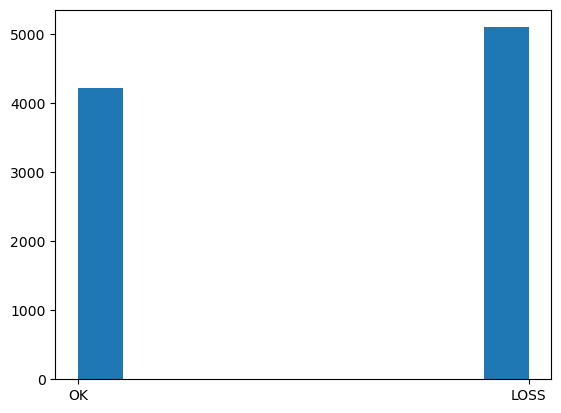

In [96]:
data_clean['LR_m']=pd.cut(x=data_clean['LR'],
                              bins=[0,1.1,max(data_clean["LR"])],
                              labels=["OK", "LOSS"],
                              include_lowest=True)
data_clean['LR_m'].describe()
plt.hist(data_clean['LR_m'])

In [97]:
print(data_clean['LR_m'].value_counts())
data_clean['LR_m'].unique()

LOSS    5102
OK      4226
Name: LR_m, dtype: int64


['OK', 'LOSS']
Categories (2, object): ['OK' < 'LOSS']

In [98]:
selected_cols = ['INSURANCE_TYPE', 'CLAIM_AMOUNT', 'MARITAL_STATUS', 'AGE', 'TENURE', 'EMPLOYMENT_STATUS', 'NO_OF_FAMILY_MEMBERS', 'RISK_SEGMENTATION', 'HOUSE_TYPE', 'SOCIAL_CLASS', 'CUSTOMER_EDUCATION_LEVEL', 'CLAIM_STATUS', 'INCIDENT_SEVERITY', 'AUTHORITY_CONTACTED', 'ANY_INJURY', 'POLICE_REPORT_AVAILABLE', 'INCIDENT_STATE', 'INCIDENT_HOUR_OF_THE_DAY', 'Cases_covid', 'CPIAUCSL', 'Year', 'Month', 'Civilian non-institutional population', 'Total labor force', 'Labor force percent of population', 'Total employment', 'Employment percent of population', 'Total Unemployment', 'Unemployment percent of population', 'STUSAB', 'stari_sml', 'GWP', 'LR', 'doba_reseni', 'odprac_rok', 'den_udalosti', 'den_hlaseni', 'PREMIUM_AMOUNT_m']
data_ml= data_clean[selected_cols]

In [99]:
data_ml.head(2)

,INSURANCE_TYPE,CLAIM_AMOUNT,MARITAL_STATUS,AGE,TENURE,EMPLOYMENT_STATUS,NO_OF_FAMILY_MEMBERS,RISK_SEGMENTATION,HOUSE_TYPE,SOCIAL_CLASS,...,Unemployment percent of population,STUSAB,stari_sml,GWP,LR,doba_reseni,odprac_rok,den_udalosti,den_hlaseni,PREMIUM_AMOUNT_m
0,Health,9000,Y,54,89,Y,3,L,Own,LI,...,9.8,AZ,59,9270.67,0.9708036204503019,11,26,Saturday,Thursday,150+
1,Property,26000,N,61,80,Y,4,L,Rent,MI,...,11.1,CO,25,3542.75,7.338931620915955,14,16,Wednesday,Monday,(125;150>


In [100]:
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier


In [101]:
data_ml["den_udalosti"].value_counts()

Saturday     1364
Friday       1356
Wednesday    1347
Sunday       1342
Monday       1333
Thursday     1319
Tuesday      1267
Name: den_udalosti, dtype: int64

In [102]:
data_ml['INSURANCE_TYPE'] = data_ml['INSURANCE_TYPE'].replace(['Life','Mobile','Health','Property','Travel','Motor'],[1,2,3,4,5,6])
data_ml['MARITAL_STATUS'] = data_ml['MARITAL_STATUS'].replace(['Y','N'],[1,0])
data_ml['EMPLOYMENT_STATUS'] = data_ml['EMPLOYMENT_STATUS'].replace(['Y','N'],[1,0])
data_ml['RISK_SEGMENTATION'] = data_ml['RISK_SEGMENTATION'].replace(['L','M','H'],[1,2,3])
data_ml['HOUSE_TYPE'] = data_ml['HOUSE_TYPE'].replace(['Mortgage','Rent','Own'],[1,2,3])
data_ml['SOCIAL_CLASS'] = data_ml['SOCIAL_CLASS'].replace(['LI','MI','HI'],[1,2,3])
data_ml['CUSTOMER_EDUCATION_LEVEL'] = data_ml['CUSTOMER_EDUCATION_LEVEL'].replace(['Bachelor','High School','Masters','College','MD','PhD',],[1,2,3,4,5,6])
data_ml['CLAIM_STATUS'] = data_ml['CLAIM_STATUS'].replace(['A','D'],[1,0])
data_ml['INCIDENT_SEVERITY'] = data_ml['INCIDENT_SEVERITY'].replace(['Minor Loss','Major Loss','Total Loss'],[1,2,3])
data_ml['AUTHORITY_CONTACTED'] = data_ml['AUTHORITY_CONTACTED'].replace(['Ambulance','Police','None','Other'],[1,2,3,3])
data_ml['INCIDENT_STATE'] = data_ml['INCIDENT_STATE'].replace(['CA','CO','FL','AZ','CT','AL','MD','OK','MA','GA','DC','TN','AR','AK','KY','VT'],[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])
data_ml['STUSAB'] = data_ml['STUSAB'].replace(['CA','CO','FL','AZ','CT','AL','MD','OK','MA','GA','DC','TN','AR','AK','KY','VT'],[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])
data_ml['den_udalosti'] = data_ml['den_udalosti'].replace(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],[1,2,3,4,5,6,7])
data_ml['den_hlaseni'] = data_ml['den_hlaseni'].replace(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],[1,2,3,4,5,6,7])

/var/folders/jm/t_0fgqb560d3w58nyxy1qmy00000gn/T/ipykernel_28554/1363036846.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_ml['INSURANCE_TYPE'] = data_ml['INSURANCE_TYPE'].replace(['Life','Mobile','Health','Property','Travel','Motor'],[1,2,3,4,5,6])
/var/folders/jm/t_0fgqb560d3w58nyxy1qmy00000gn/T/ipykernel_28554/1363036846.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_ml['MARITAL_STATUS'] = data_ml['MARITAL_STATUS'].replace(['Y','N'],[1,0])
/var/folders/jm/t_0fgqb560d3w58nyxy1qmy00000g

# Rozhodovací Strom

In [103]:
X = data_ml.drop('PREMIUM_AMOUNT_m', axis=1)
y = data_ml['PREMIUM_AMOUNT_m']

In [104]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [105]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [106]:
RF = RandomForestClassifier(n_estimators=100, max_depth=6, random_state=42)

RF.fit(X_train,y_train)
y_pred = RF.predict(X_test)

In [107]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
print('Accuracy Score Statistics')
print('Random Forest score on train set is:', RF.score(X_train, y_train))
print('Random Forest score on test set is:', RF.score(X_test, y_test))
print('Accuracy score (absolute) is:', accuracy_score(y_test, y_pred, normalize=False))

Accuracy Score Statistics
Random Forest score on train set is: 0.6417083631165118
Random Forest score on test set is: 0.5664523043944266
Accuracy score (absolute) is: 2114


In [108]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, labels=np.unique(y_pred)))

[[196  21   0 328  27   0]
 [151  58   0 202  71   0]
 [  0   0 254 440   0   0]
 [ 24   0 138 784   0   0]
 [136  17   0  63 178   0]
 [  0   0   0   0   0 644]]
              precision    recall  f1-score   support

   (100;125>       0.39      0.34      0.36       572
   (125;150>       0.60      0.12      0.20       482
     (50;75>       0.65      0.37      0.47       694
    (75;100>       0.43      0.83      0.57       946
        150+       0.64      0.45      0.53       394
      <0;50>       1.00      1.00      1.00       644

    accuracy                           0.57      3732
   macro avg       0.62      0.52      0.52      3732
weighted avg       0.61      0.57      0.54      3732



In [109]:
from sklearn.model_selection import cross_val_score

performance = cross_val_score(estimator = RF, X = X_train, y = y_train, cv = 3)

print('Cross Validation Statistics')
print('Best Accuracy      : ', performance.mean())
print('Best Std Deviation : ', performance.std())

Cross Validation Statistics
Best Accuracy      :  0.5761260963557455
Best Std Deviation :  0.003688325328571323


In [110]:
from sklearn.model_selection import GridSearchCV

parameters = [{'n_estimators' : [i for i in range(50, 201, 20)], 'criterion' : ['gini', 'entropy']}]
grid_search = GridSearchCV(estimator = RF, param_grid = parameters, scoring = 'accuracy', cv = 3)
grid_search.fit(X_train, y_train)

print('Grid Search Statistics')
print('Best Accuracy : ', grid_search.best_score_)
print('Best Params : ', grid_search.best_params_)

Grid Search Statistics
Best Accuracy :  0.5830916250250233
Best Params :  {'criterion': 'entropy', 'n_estimators': 90}


In [111]:
y_pred = grid_search.predict(X_test)
print(classification_report(y_test, y_pred, labels=np.unique(y_pred)))

              precision    recall  f1-score   support

   (100;125>       0.38      0.37      0.38       572
   (125;150>       0.58      0.09      0.15       482
     (50;75>       0.65      0.38      0.48       694
    (75;100>       0.43      0.81      0.56       946
        150+       0.67      0.46      0.55       394
      <0;50>       1.00      1.00      1.00       644

    accuracy                           0.57      3732
   macro avg       0.62      0.52      0.52      3732
weighted avg       0.61      0.57      0.54      3732



# Logisticka regrese

In [112]:
#redifine data_ml
selected_cols = ['INSURANCE_TYPE', 'CLAIM_AMOUNT','PREMIUM_AMOUNT', 'MARITAL_STATUS', 'AGE', 'TENURE', 'EMPLOYMENT_STATUS', 'NO_OF_FAMILY_MEMBERS', 'RISK_SEGMENTATION', 'HOUSE_TYPE', 'SOCIAL_CLASS', 'CUSTOMER_EDUCATION_LEVEL', 'CLAIM_STATUS', 'INCIDENT_SEVERITY', 'AUTHORITY_CONTACTED', 'ANY_INJURY', 'POLICE_REPORT_AVAILABLE', 'INCIDENT_STATE', 'INCIDENT_HOUR_OF_THE_DAY', 'Cases_covid', 'CPIAUCSL', 'Year', 'Month', 'Civilian non-institutional population', 'Total labor force', 'Labor force percent of population', 'Total employment', 'Employment percent of population', 'Total Unemployment', 'Unemployment percent of population', 'STUSAB', 'stari_sml', 'GWP', 'doba_reseni', 'odprac_rok', 'den_udalosti', 'den_hlaseni', 'LR_m']
data_ml= data_clean[selected_cols]

In [113]:
print(data_ml['LR_m'].value_counts())
data_ml['LR_m'].unique()

LOSS    5102
OK      4226
Name: LR_m, dtype: int64


['OK', 'LOSS']
Categories (2, object): ['OK' < 'LOSS']

In [114]:
data_ml['INSURANCE_TYPE'] = data_ml['INSURANCE_TYPE'].replace(['Life','Mobile','Health','Property','Travel','Motor'],[1,2,3,4,5,6])
data_ml['MARITAL_STATUS'] = data_ml['MARITAL_STATUS'].replace(['Y','N'],[1,0])
data_ml['EMPLOYMENT_STATUS'] = data_ml['EMPLOYMENT_STATUS'].replace(['Y','N'],[1,0])
data_ml['RISK_SEGMENTATION'] = data_ml['RISK_SEGMENTATION'].replace(['L','M','H'],[1,2,3])
data_ml['HOUSE_TYPE'] = data_ml['HOUSE_TYPE'].replace(['Mortgage','Rent','Own'],[1,2,3])
data_ml['SOCIAL_CLASS'] = data_ml['SOCIAL_CLASS'].replace(['LI','MI','HI'],[1,2,3])
data_ml['CUSTOMER_EDUCATION_LEVEL'] = data_ml['CUSTOMER_EDUCATION_LEVEL'].replace(['Bachelor','High School','Masters','College','MD','PhD',],[1,2,3,4,5,6])
data_ml['CLAIM_STATUS'] = data_ml['CLAIM_STATUS'].replace(['A','D'],[1,0])
data_ml['INCIDENT_SEVERITY'] = data_ml['INCIDENT_SEVERITY'].replace(['Minor Loss','Major Loss','Total Loss'],[1,2,3])
data_ml['AUTHORITY_CONTACTED'] = data_ml['AUTHORITY_CONTACTED'].replace(['Ambulance','Police','None','Other'],[1,2,3,3])
data_ml['INCIDENT_STATE'] = data_ml['INCIDENT_STATE'].replace(['CA','CO','FL','AZ','CT','AL','MD','OK','MA','GA','DC','TN','AR','AK','KY','VT'],[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])
data_ml['STUSAB'] = data_ml['STUSAB'].replace(['CA','CO','FL','AZ','CT','AL','MD','OK','MA','GA','DC','TN','AR','AK','KY','VT'],[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])
data_ml['den_udalosti'] = data_ml['den_udalosti'].replace(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],[1,2,3,4,5,6,7])
data_ml['den_hlaseni'] = data_ml['den_hlaseni'].replace(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],[1,2,3,4,5,6,7])
data_ml['LR_m'] = data_ml['LR_m'].replace(['OK','LOSS'],[1,0])

/var/folders/jm/t_0fgqb560d3w58nyxy1qmy00000gn/T/ipykernel_28554/44462556.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_ml['INSURANCE_TYPE'] = data_ml['INSURANCE_TYPE'].replace(['Life','Mobile','Health','Property','Travel','Motor'],[1,2,3,4,5,6])
/var/folders/jm/t_0fgqb560d3w58nyxy1qmy00000gn/T/ipykernel_28554/44462556.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_ml['MARITAL_STATUS'] = data_ml['MARITAL_STATUS'].replace(['Y','N'],[1,0])
/var/folders/jm/t_0fgqb560d3w58nyxy1qmy00000gn/T/

In [115]:
# Import the necessary modules
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score


# Redifining X and y
X_bin = data_ml.drop(['LR_m'], axis=1)
y_bin = data_ml['LR_m']

#Normalizing again for binarized 'quality'
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_bin = scaler.fit_transform(X_bin)

# Create training and test sets
X_bin_train, X_bin_test, y_bin_train, y_bin_test = train_test_split(X_bin, y_bin, test_size = 0.3, random_state=42)

# Create the classifier: logreg
logreg = LogisticRegression()

# Fit the classifier to the training data
logreg.fit(X_bin_train,y_bin_train)

# Predict the labels of the test set: y_pred
y_bin_pred = logreg.predict(X_bin_test)

In [116]:
print(confusion_matrix(y_bin_test, y_bin_pred))
print(classification_report(y_bin_test, y_bin_pred))

[[1454   67]
 [  55 1223]]
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1521
           1       0.95      0.96      0.95      1278

    accuracy                           0.96      2799
   macro avg       0.96      0.96      0.96      2799
weighted avg       0.96      0.96      0.96      2799



# Optional SD4FT

## Unemployment data prep

In [117]:
data_clean.columns

Index(['TXN_DATE_TIME', 'TRANSACTION_ID', 'CUSTOMER_ID', 'POLICY_NUMBER',
       'POLICY_EFF_DT', 'LOSS_DT', 'REPORT_DT', 'INSURANCE_TYPE',
       'PREMIUM_AMOUNT', 'CLAIM_AMOUNT', 'CUSTOMER_NAME', 'ADDRESS_LINE1_x',
       'CITY_x', 'STATE_x', 'POSTAL_CODE_x', 'SSN', 'MARITAL_STATUS', 'AGE',
       'TENURE', 'EMPLOYMENT_STATUS', 'NO_OF_FAMILY_MEMBERS',
       'RISK_SEGMENTATION', 'HOUSE_TYPE', 'SOCIAL_CLASS', 'ROUTING_NUMBER',
       'ACCT_NUMBER', 'CUSTOMER_EDUCATION_LEVEL', 'CLAIM_STATUS',
       'INCIDENT_SEVERITY', 'AUTHORITY_CONTACTED', 'ANY_INJURY',
       'POLICE_REPORT_AVAILABLE', 'INCIDENT_STATE', 'INCIDENT_CITY',
       'INCIDENT_HOUR_OF_THE_DAY', 'AGENT_ID', 'AGENT_NAME', 'DATE_OF_JOINING',
       'ADDRESS_LINE1_y', 'CITY_y', 'STATE_y', 'POSTAL_CODE_y',
       'EMP_ROUTING_NUMBER', 'EMP_ACCT_NUMBER', 'Date_covid', 'Cases_covid',
       'CPIAUCSL', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'FIPS Code', 'State and area', 'Year', 'Month',
       'Civilian n

In [118]:
data_clean['Unemployment percent of population'] = data_clean['Unemployment percent of population'].astype(float)
data_clean['Unemployment percent of population']

0        9.8
1       11.1
2       14.2
3        8.6
4       14.2
        ... 
9995     6.2
9996     6.2
9997     6.2
9998     6.2
9999     6.2
Name: Unemployment percent of population, Length: 9328, dtype: float64

In [119]:
bins = [0, 5, 10, np.inf]
data_clean['Unemployment_bin'] = pd.cut(data_clean['Unemployment percent of population'], bins, labels= ['0% - 8%', '8% - 13%', '13% - inf'])
data_clean['Unemployment_bin']

0        8% - 13%
1       13% - inf
2       13% - inf
3        8% - 13%
4       13% - inf
          ...    
9995     8% - 13%
9996     8% - 13%
9997     8% - 13%
9998     8% - 13%
9999     8% - 13%
Name: Unemployment_bin, Length: 9328, dtype: category
Categories (3, object): ['0% - 8%' < '8% - 13%' < '13% - inf']

(array([5795.,    0.,    0.,    0.,    0.,  715.,    0.,    0.,    0.,
        2818.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

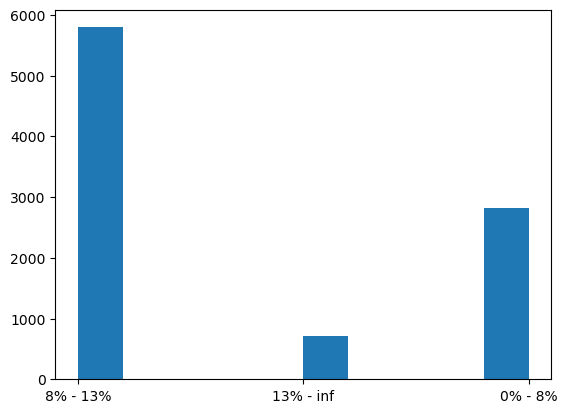

In [120]:
plt.hist(data_clean['Unemployment_bin'])

## SD4FT

In [121]:
Optional_SD4FT_miner_2 = cleverminer(df=data_clean[data_clean['INSURANCE_TYPE'] == 'Motor'],proc='SD4ftMiner',
               quantifiers= {'Base1':10, 'Base2':10, 'Ratioconf' : 1.5},
               ante ={
                    'attributes':[
                        {'name': 'AGE_m', 'type': 'seq', 'minlen': 1, 'maxlen': 3},
                    ], 'minlen':1, 'maxlen':1, 'type':'con'},
               succ ={
                    'attributes':[
                        {'name': 'CLAIM_AMOUNT_m', 'type': 'subset', 'minlen': 1, 'maxlen': 1},
                    ], 'minlen':1, 'maxlen':1, 'type':'con'},
               frst ={
                    'attributes':[
                        {'name': 'Unemployment_bin', 'type': 'subset', 'minlen': 1, 'maxlen': 1},
                    ], 'minlen':1, 'maxlen':1, 'type':'con'},
               scnd ={
                    'attributes':[
                        {'name': 'Unemployment_bin', 'type': 'subset', 'minlen': 1, 'maxlen': 1},
                    ], 'minlen':1, 'maxlen':1, 'type':'con'}
               )

Optional_SD4FT_miner_2.print_summary()

Cleverminer version 1.0.2. Note: This version is for personal and educational use only. If you need PRO version (support, fixing structures for compactibility in future versions for production deployment, additional development, licensing of commercial use of subroutines used), feel free to ask authors. Most of these functionalities are maintained in best-effort, as soon as this project is at given conditions for free use and rapid development is needed, they cannot be guaranteed.
Starting data preparation ...
Encoding columns into bit-form...


/Users/danielmalinovsky/opt/anaconda3/envs/vseML/lib/python3.9/site-packages/cleverminer/cleverminer.py:145: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  OOOOO00OO0O000O0O [O000OOO0000OOOO0O ]=OOOOO00OO0O000O0O [O000OOO0000OOOO0O ].apply (str )#line:209


Encoding columns into bit-form...done
Data preparation finished.
Will go for  SD4ftMiner
Starting to mine rules.
Done. Total verifications : 648, rules 10,control number:0, times: prep 1.042896032333374, processing 0.05300712585449219

CleverMiner task processing summary:

Task type : SD4ftMiner
Number of verifications : 648
Number of rules : 10
Total time needed : 00h 00m 01s
Time of data preparation : 00h 00m 01s
Time of rule mining : 00h 00m 00s



In [122]:
Optional_SD4FT_miner_2.print_rulelist()


List of rules:
RULEID BASE1 BASE2 RatioConf DeltaConf Rule
     1    60    15    1.776    +0.058  AGE_m(31 to 40 41 to 50) => CLAIM_AMOUNT_m((1000;2000>) | --- : Unemployment_bin(8% - 13%) x Unemployment_bin(0% - 8%)
     2    45    14    1.678    +0.040  AGE_m(41 to 50 51 to 60) => CLAIM_AMOUNT_m((2000;3000>) | --- : Unemployment_bin(8% - 13%) x Unemployment_bin(0% - 8%)
     3    53    16    1.737    +0.042  AGE_m(41 to 50 51 to 60 60+) => CLAIM_AMOUNT_m((2000;3000>) | --- : Unemployment_bin(8% - 13%) x Unemployment_bin(0% - 8%)
     4    13    25    1.601    +0.055  AGE_m(20 to 30 31 to 40 41 to 50) => CLAIM_AMOUNT_m((1000;2000>) | --- : Unemployment_bin(13% - inf) x Unemployment_bin(0% - 8%)
     5    10    15    1.980    +0.073  AGE_m(31 to 40 41 to 50) => CLAIM_AMOUNT_m((1000;2000>) | --- : Unemployment_bin(13% - inf) x Unemployment_bin(0% - 8%)
     6    15    26    2.016    +0.080  AGE_m(31 to 40 41 to 50 51 to 60) => CLAIM_AMOUNT_m((1000;2000>) | --- : Unemployment_bin(13% - 

In [123]:
Optional_SD4FT_miner_2.print_rule(7)



Rule id : 7

Base1 :    13 Base2 :    21  Relative base 1 : 0.009 Relative base 2 : 0.014 CONF1 : 0.200  CONF2 : +0.089  Delta Conf : +0.111 Ratio Conf : +2.248

Cedents:
  antecedent : AGE_m(41 to 50 51 to 60)
  succcedent : CLAIM_AMOUNT_m((1000;2000>)
  condition  : ---
  first set  : Unemployment_bin(13% - inf)
  second set : Unemployment_bin(0% - 8%)

Fourfold tables:
FRST|  S  |  ¬S |  SCND|  S  |  ¬S |
----|-----|-----|  ----|-----|-----| 
 A  |   13|   52|   A  |   21|  215|
----|-----|-----|  ----|-----|-----|
¬A  |    6|   57|  ¬A  |   24|  189|
----|-----|-----|  ----|-----|-----|



Test tasks